In [1]:
import pandas as pd
import numpy as np
from matplotlib.ticker import LogFormatter
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import json
import plategig
import re

PROJECT_PATH = Path('/Users/wak/home2/plategig/projects/Tested_Variants_MIC_Estimations')
PROJECT_ID = ''

#### Step 1: Read Plate Information

In [2]:
# Read the Excel file into a DataFrame
df_plate_info = pd.read_excel(PROJECT_PATH / "data/PlateInfo_250516_250520_250407.xlsx", engine='openpyxl')
df_plate_info.rename(columns={'Plate': 'Plate_ID'}, inplace=True)
df_plate_info

Experiment  Plate_ID Well      Strain  Culture  Replicate Antibiotic  \
0              1         1   A1  Media Only      NaN        NaN        NaN   
1              1         1   A2  Media Only      NaN        NaN        NaN   
2              1         1   A3  Media Only      NaN        NaN        NaN   
3              1         1   A4  Media Only      NaN        NaN        NaN   
4              1         1   A5  Media Only      NaN        NaN        NaN   
...          ...       ...  ...         ...      ...        ...        ...   
3835           1        40   H8  Media Only      NaN        NaN        NaN   
3836           1        40   H9  Media Only      NaN        NaN        NaN   
3837           1        40  H10  Media Only      NaN        NaN        NaN   
3838           1        40  H11  Media Only      NaN        NaN        NaN   
3839           1        40  H12  Media Only      NaN        NaN        NaN   

      Dose  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN  
...    ...  
3835   NaN  
3836   NaN  
3837   NaN  
3838   NaN  
3839   NaN  

[3840 rows x 8 columns]

Collect unique plate IDs

#### Step 2: Read the raw OD data

In [3]:
df = plategig.static.read_OD_data(PROJECT_PATH / "data/ODFinal_250516_250520_250407.xlsx", df_plate_info)
df

Plate_ID Well     OD  Row  Column
0            1   A1  0.051    1       1
1            1   A2  0.052    1       2
2            1   A3  0.051    1       3
3            1   A4  0.050    1       4
4            1   A5  0.051    1       5
...        ...  ...    ...  ...     ...
3835        40   H8  0.046    8       8
3836        40   H9  0.044    8       9
3837        40  H10  0.047    8      10
3838        40  H11  0.045    8      11
3839        40  H12  0.046    8      12

[3840 rows x 5 columns]

Calculate median background of all plates to impute plates with missing media-only wells.

In [4]:
df_plate_info[df_plate_info['Strain']=='Cells Only']

Empty DataFrame
Columns: [Experiment, Plate_ID, Well, Strain, Culture, Replicate, Antibiotic, Dose]
Index: []

In [5]:
pd.DataFrame(df_plate_info[['Strain','Antibiotic','Dose']].value_counts()).to_csv(PROJECT_PATH / 'test.csv')

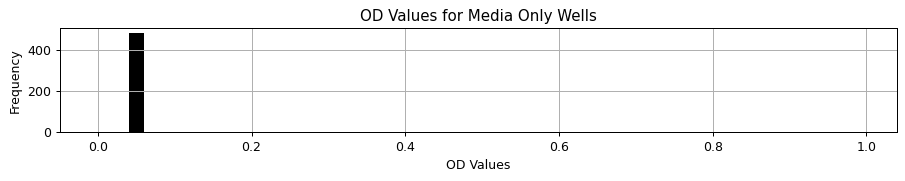

0.0495


In [6]:
median_background_all_plates = plategig.static.calc_median_background_all_plates(
    df, df_plate_info, plot=True)
#I had to make these changes because there was a problem with the plate map info, confirm with Adam.
print(median_background_all_plates)

Apply background correction for all plates

In [7]:
df_bc = df.copy()
df_bc['OD_final'] = df_bc['OD'] - median_background_all_plates

#### Evaluate growth metrics

In [8]:
df_bc

Plate_ID Well     OD  Row  Column  OD_final
0            1   A1  0.051    1       1    0.0015
1            1   A2  0.052    1       2    0.0025
2            1   A3  0.051    1       3    0.0015
3            1   A4  0.050    1       4    0.0005
4            1   A5  0.051    1       5    0.0015
...        ...  ...    ...  ...     ...       ...
3835        40   H8  0.046    8       8   -0.0035
3836        40   H9  0.044    8       9   -0.0055
3837        40  H10  0.047    8      10   -0.0025
3838        40  H11  0.045    8      11   -0.0045
3839        40  H12  0.046    8      12   -0.0035

[3840 rows x 6 columns]

In [9]:
# Prep the analysis dataframe
df_analysis = pd.merge(df_plate_info, df_bc, on=['Plate_ID', 'Well'])
df_analysis = df_analysis[['Experiment','Strain', 'Culture', 'Replicate', 'Antibiotic',
                           'Dose', 'Plate_ID', 'Well', 'Row', 'Column',
                           'OD', 'OD_final']]
# Remove control wells
df_analysis = df_analysis[~df_analysis['Strain'].isin(['Media Only','Cells Only'])]
# Keep group names
df_analysis['Group'] = df_analysis.Strain
# Define each culture of as a separate strain
# df_analysis['Strain'] = df_analysis.Strain + df_analysis.Culture.astype(int).astype(str)
df_analysis


Experiment  Strain  Culture  Replicate  Antibiotic          Dose  \
12             1  NEB10B      1.0        1.0  Ampicillin  30000.000000   
13             1  NEB10B      1.0        1.0  Ampicillin  10000.000000   
14             1  NEB10B      1.0        1.0  Ampicillin   3333.333333   
15             1  NEB10B      1.0        1.0  Ampicillin   1111.111111   
16             1  NEB10B      1.0        1.0  Ampicillin    370.370370   
...          ...     ...      ...        ...         ...           ...   
3823           1     SML      1.0        3.0   Meropenem      0.007316   
3824           1     SML      1.0        3.0   Meropenem      0.002439   
3825           1     SML      1.0        3.0   Meropenem      0.000813   
3826           1     SML      1.0        3.0   Meropenem      0.000271   
3827           1     SML      1.0        3.0   Meropenem      0.000000   

      Plate_ID Well  Row  Column     OD  OD_final   Group  
12           1   B1    2       1  0.045   -0.0045  NEB10B  
13           1   B2    2       2  0.044   -0.0055  NEB10B  
14           1   B3    2       3  0.044   -0.0055  NEB10B  
15           1   B4    2       4  0.044   -0.0055  NEB10B  
16           1   B5    2       5  0.044   -0.0055  NEB10B  
...        ...  ...  ...     ...    ...       ...     ...  
3823        40   G8    7       8  0.356    0.3065     SML  
3824        40   G9    7       9  0.302    0.2525     SML  
3825        40  G10    7      10  0.293    0.2435     SML  
3826        40  G11    7      11  0.298    0.2485     SML  
3827        40  G12    7      12  0.687    0.6375     SML  

[2880 rows x 13 columns]

In [10]:
unique_groups = df_analysis['Group'].unique().tolist()
print(unique_groups)

['NEB10B', 'TEM-1', 'SML', 'TEM-1-E166D', 'TEM-1-E166G', 'TEM-1-E166H', 'TEM-1-E166P', 'TEM-1-E166P-E168A', 'TEM-1-E166P-N170A', 'TEM-1-E166P-E168A-N170A', 'TEM-1-R164S', 'TEM-1-R164N-E166P', 'TEM-1-R164N', 'TEM-1-K73A', 'TEM-1-N132A', 'TEM-1-K73A-E166P', 'TEM-1-N132A-E166P']


In [11]:
### Double check
unique_columns = df_analysis.columns.tolist()

# Print the list of unique columns
print(unique_columns)

#
unique_values = df_analysis['Strain'].unique()

# Print the unique values
print(unique_values)

['Experiment', 'Strain', 'Culture', 'Replicate', 'Antibiotic', 'Dose', 'Plate_ID', 'Well', 'Row', 'Column', 'OD', 'OD_final', 'Group']
['NEB10B' 'TEM-1' 'SML' 'TEM-1-E166D' 'TEM-1-E166G' 'TEM-1-E166H'
 'TEM-1-E166P' 'TEM-1-E166P-E168A' 'TEM-1-E166P-N170A'
 'TEM-1-E166P-E168A-N170A' 'TEM-1-R164S' 'TEM-1-R164N-E166P' 'TEM-1-R164N'
 'TEM-1-K73A' 'TEM-1-N132A' 'TEM-1-K73A-E166P' 'TEM-1-N132A-E166P']


In [12]:
antibiotics = df_analysis['Antibiotic'].dropna().unique()
antibiotics

array(['Ampicillin', 'Ceftazidime', 'Cefotaxime', 'Ceftriaxone',
       'Cefepime', 'Aztreonam', 'Imipenem', 'Meropenem'], dtype=object)

In [13]:
df_analysis.query("Antibiotic == 'Cefotaxime' & Strain == 'NEB10B'")

Experiment  Strain  Culture  Replicate  Antibiotic       Dose  Plate_ID  \
1644           1  NEB10B      1.0        1.0  Cefotaxime  32.000000        18   
1645           1  NEB10B      1.0        1.0  Cefotaxime  10.666667        18   
1646           1  NEB10B      1.0        1.0  Cefotaxime   3.555556        18   
1647           1  NEB10B      1.0        1.0  Cefotaxime   1.185185        18   
1648           1  NEB10B      1.0        1.0  Cefotaxime   0.395062        18   
1649           1  NEB10B      1.0        1.0  Cefotaxime   0.131687        18   
1650           1  NEB10B      1.0        1.0  Cefotaxime   0.043896        18   
1651           1  NEB10B      1.0        1.0  Cefotaxime   0.014632        18   
1652           1  NEB10B      1.0        1.0  Cefotaxime   0.004877        18   
1653           1  NEB10B      1.0        1.0  Cefotaxime   0.001626        18   
1654           1  NEB10B      1.0        1.0  Cefotaxime   0.000542        18   
1655           1  NEB10B      1.0        1.0  Cefotaxime   0.000000        18   
1656           1  NEB10B      1.0        2.0  Cefotaxime  32.000000        18   
1657           1  NEB10B      1.0        2.0  Cefotaxime  10.666667        18   
1658           1  NEB10B      1.0        2.0  Cefotaxime   3.555556        18   
1659           1  NEB10B      1.0        2.0  Cefotaxime   1.185185        18   
1660           1  NEB10B      1.0        2.0  Cefotaxime   0.395062        18   
1661           1  NEB10B      1.0        2.0  Cefotaxime   0.131687        18   
1662           1  NEB10B      1.0        2.0  Cefotaxime   0.043896        18   
1663           1  NEB10B      1.0        2.0  Cefotaxime   0.014632        18   
1664           1  NEB10B      1.0        2.0  Cefotaxime   0.004877        18   
1665           1  NEB10B      1.0        2.0  Cefotaxime   0.001626        18   
1666           1  NEB10B      1.0        2.0  Cefotaxime   0.000542        18   
1667           1  NEB10B      1.0        2.0  Cefotaxime   0.000000        18   
1668           1  NEB10B      1.0        3.0  Cefotaxime  32.000000        18   
1669           1  NEB10B      1.0        3.0  Cefotaxime  10.666667        18   
1670           1  NEB10B      1.0        3.0  Cefotaxime   3.555556        18   
1671           1  NEB10B      1.0        3.0  Cefotaxime   1.185185        18   
1672           1  NEB10B      1.0        3.0  Cefotaxime   0.395062        18   
1673           1  NEB10B      1.0        3.0  Cefotaxime   0.131687        18   
1674           1  NEB10B      1.0        3.0  Cefotaxime   0.043896        18   
1675           1  NEB10B      1.0        3.0  Cefotaxime   0.014632        18   
1676           1  NEB10B      1.0        3.0  Cefotaxime   0.004877        18   
1677           1  NEB10B      1.0        3.0  Cefotaxime   0.001626        18   
1678           1  NEB10B      1.0        3.0  Cefotaxime   0.000542        18   
1679           1  NEB10B      1.0        3.0  Cefotaxime   0.000000        18   

     Well  Row  Column     OD  OD_final   Group  
1644   B1    2       1  0.046   -0.0035  NEB10B  
1645   B2    2       2  0.045   -0.0045  NEB10B  
1646   B3    2       3  0.047   -0.0025  NEB10B  
1647   B4    2       4  0.045   -0.0045  NEB10B  
1648   B5    2       5  0.046   -0.0035  NEB10B  
1649   B6    2       6  0.045   -0.0045  NEB10B  
1650   B7    2       7  0.203    0.1535  NEB10B  
1651   B8    2       8  0.355    0.3055  NEB10B  
1652   B9    2       9  0.430    0.3805  NEB10B  
1653  B10    2      10  0.531    0.4815  NEB10B  
1654  B11    2      11  0.531    0.4815  NEB10B  
1655  B12    2      12  0.498    0.4485  NEB10B  
1656   C1    3       1  0.046   -0.0035  NEB10B  
1657   C2    3       2  0.045   -0.0045  NEB10B  
1658   C3    3       3  0.046   -0.0035  NEB10B  
1659   C4    3       4  0.046   -0.0035  NEB10B  
1660   C5    3       5  0.045   -0.0045  NEB10B  
1661   C6    3       6  0.045   -0.0045  NEB10B  
1662   C7    3       7  0.221    0.1715  NEB10B  
1663   C

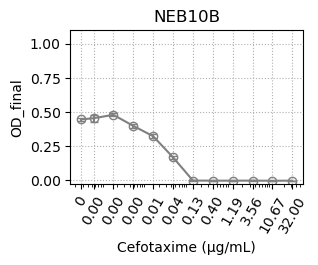

In [14]:

# Adjust the figure size as needed
fig, ax = plt.subplots(figsize=(3, 2))
plategig.static.plot_dose_response_curve_errorbar(df_analysis, 'NEB10B', 'Cefotaxime', strain_colors={'P1':'black'}, ax=ax)

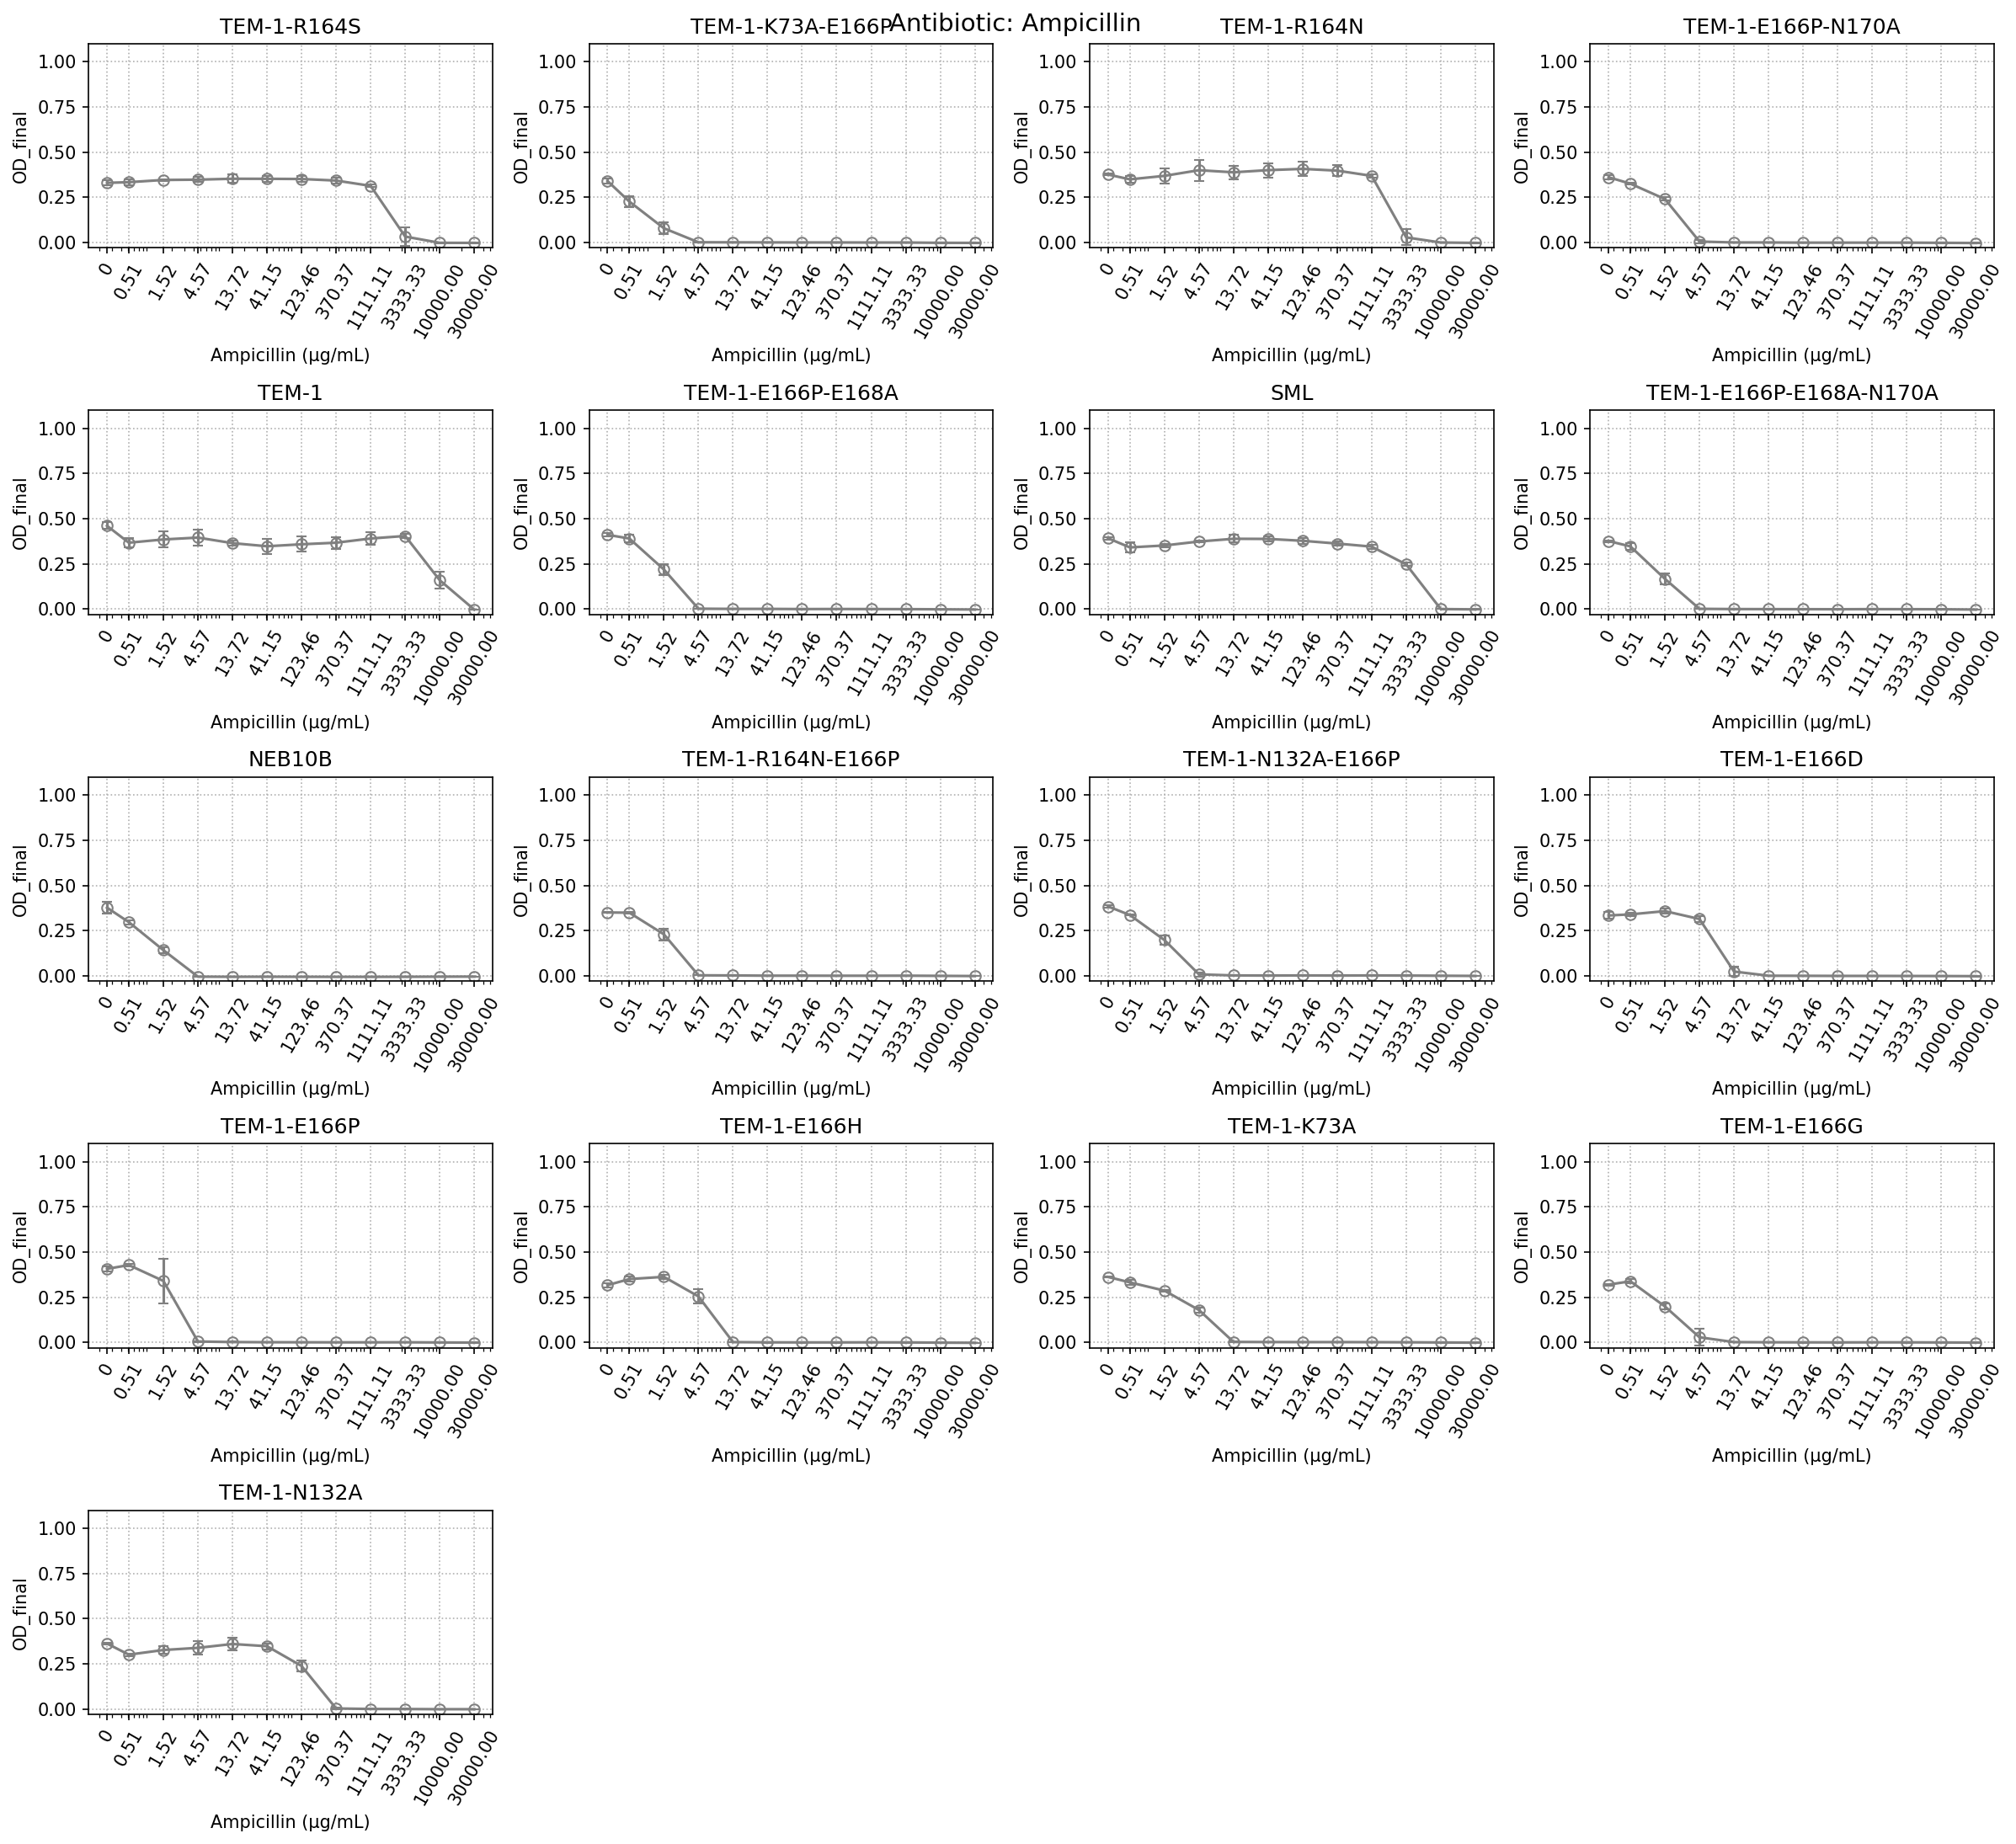

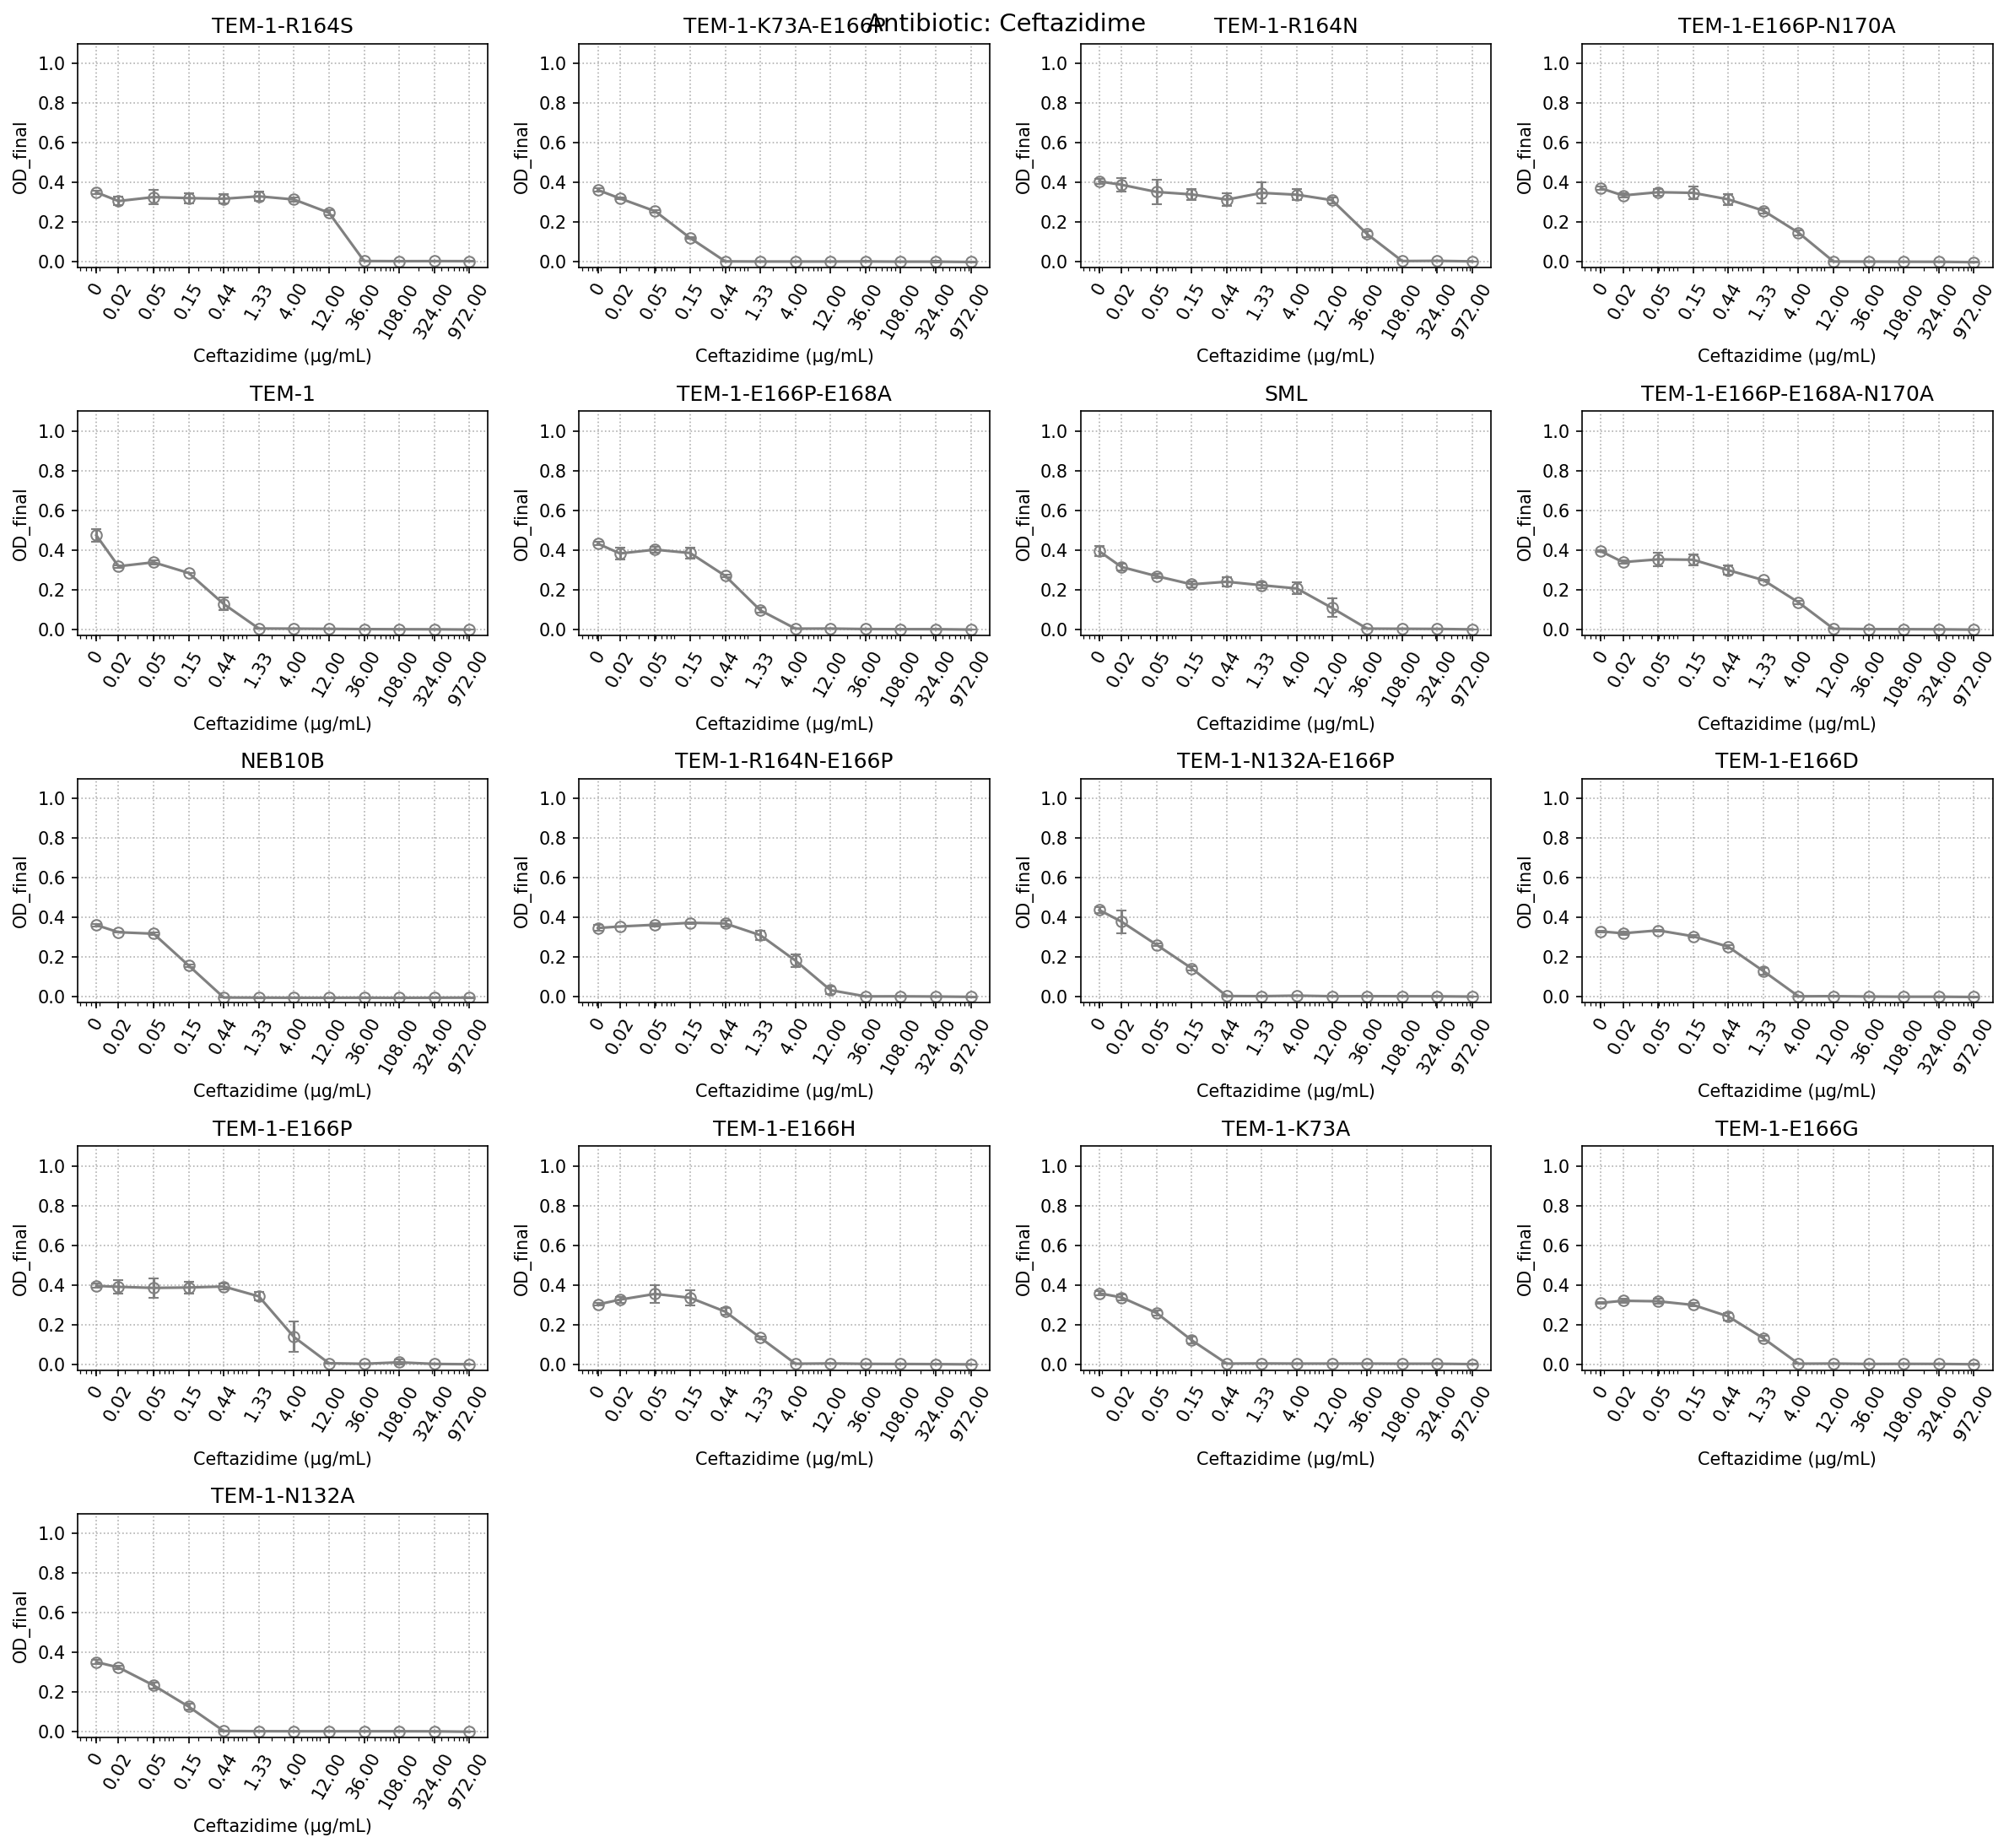

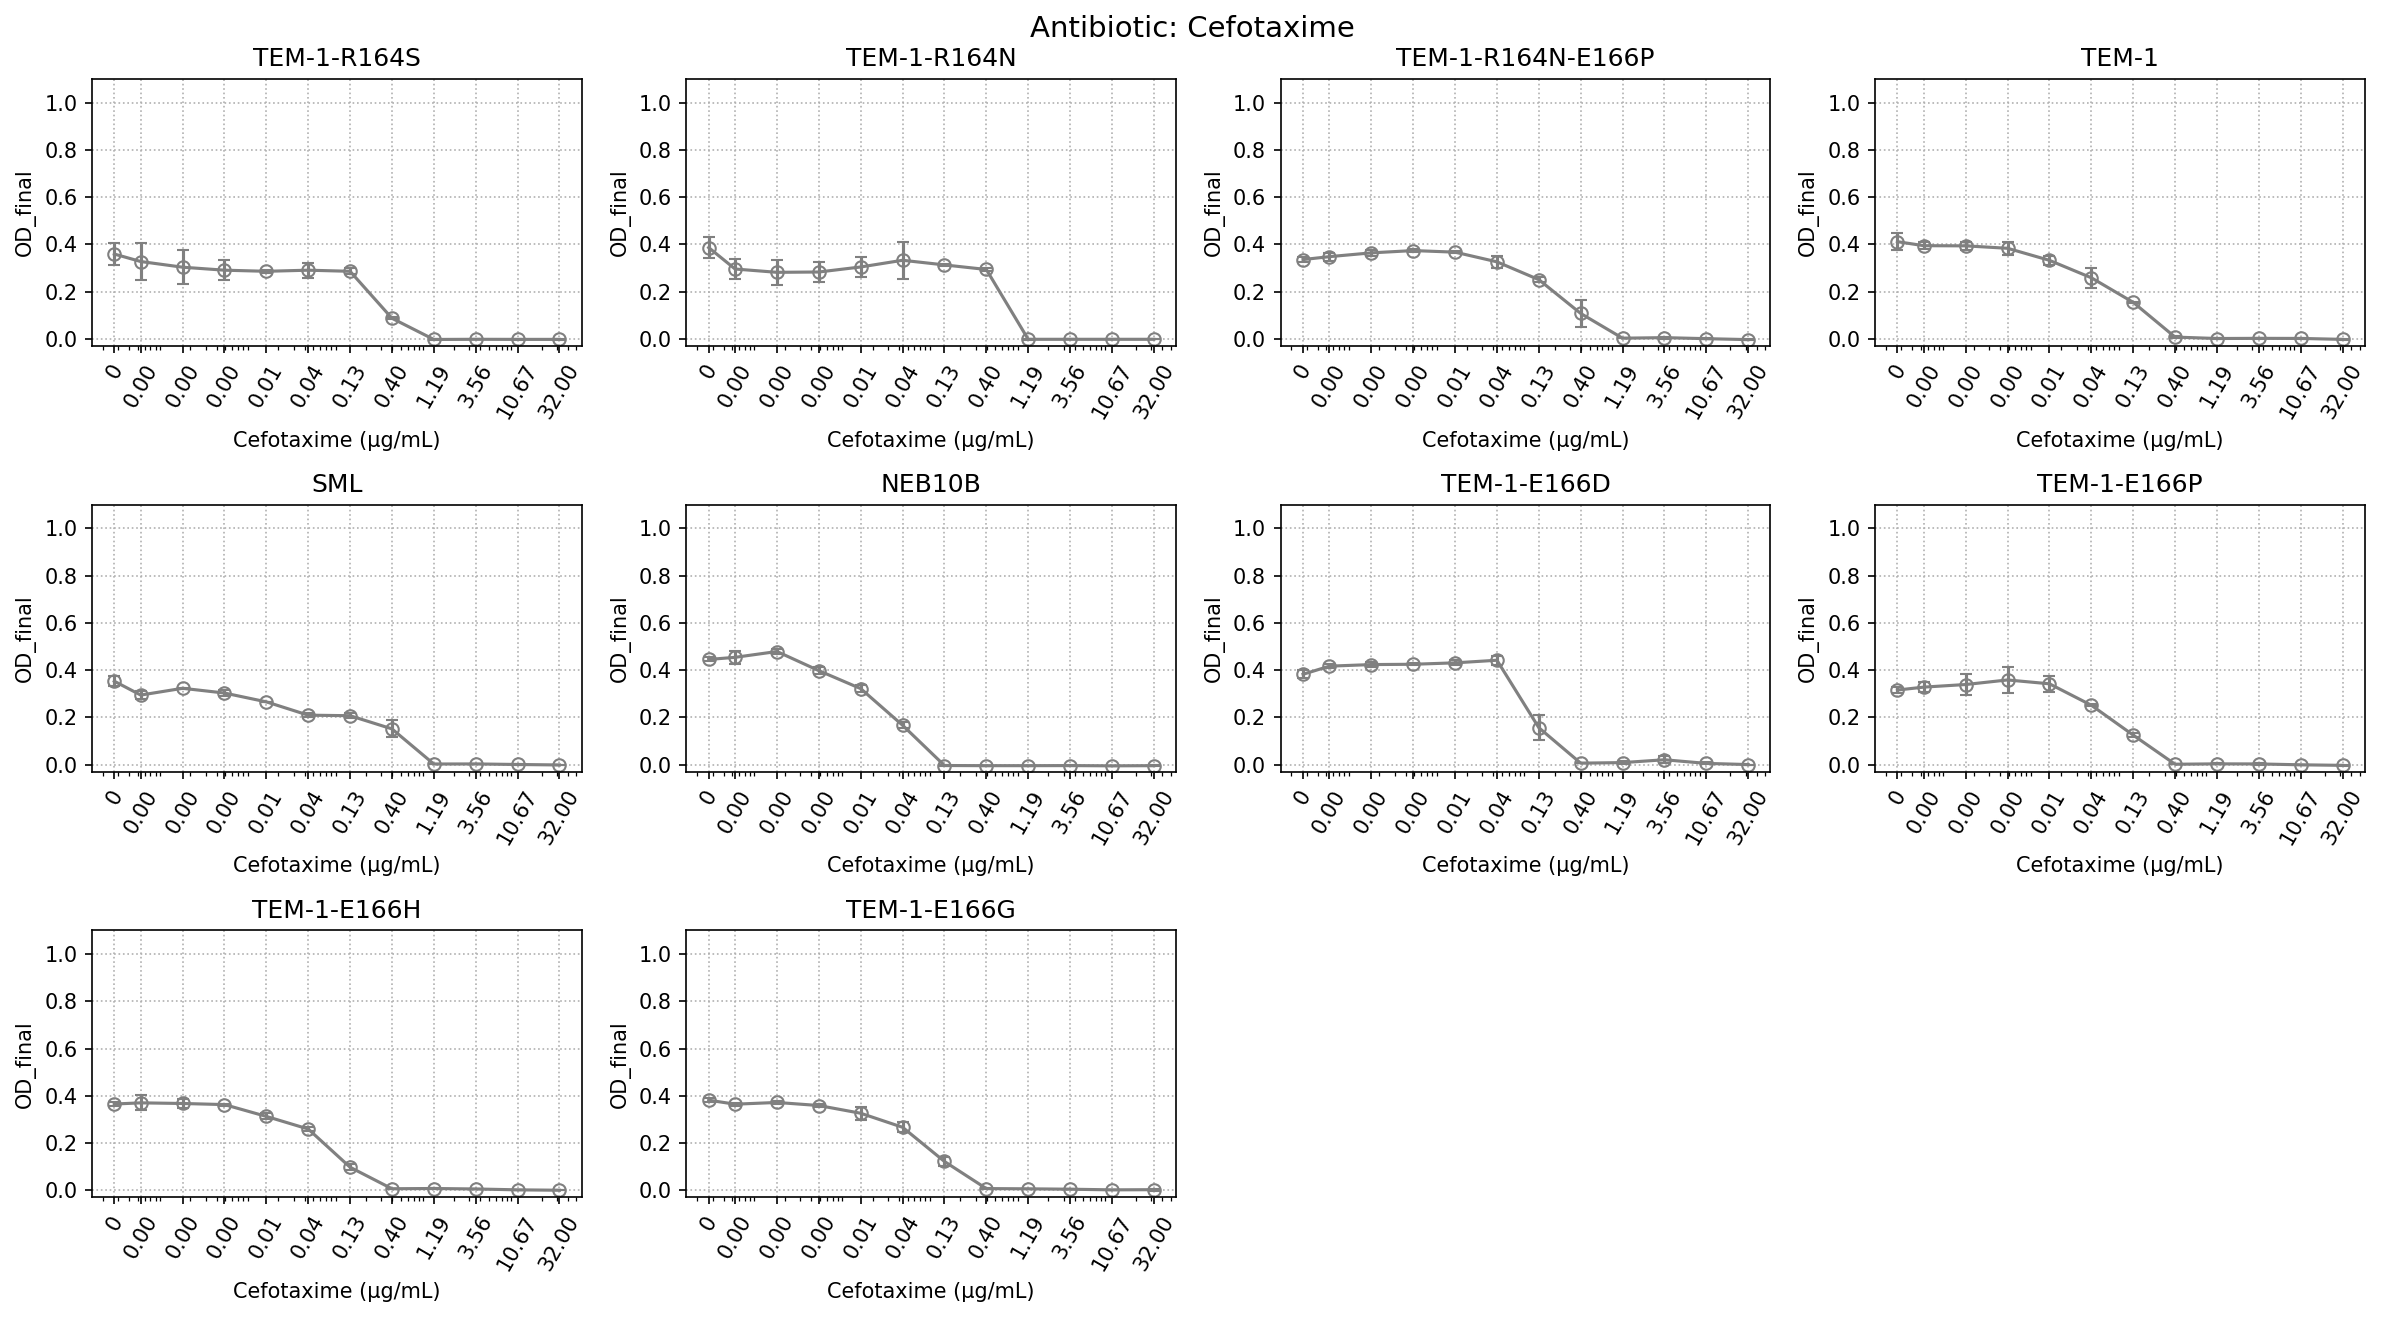

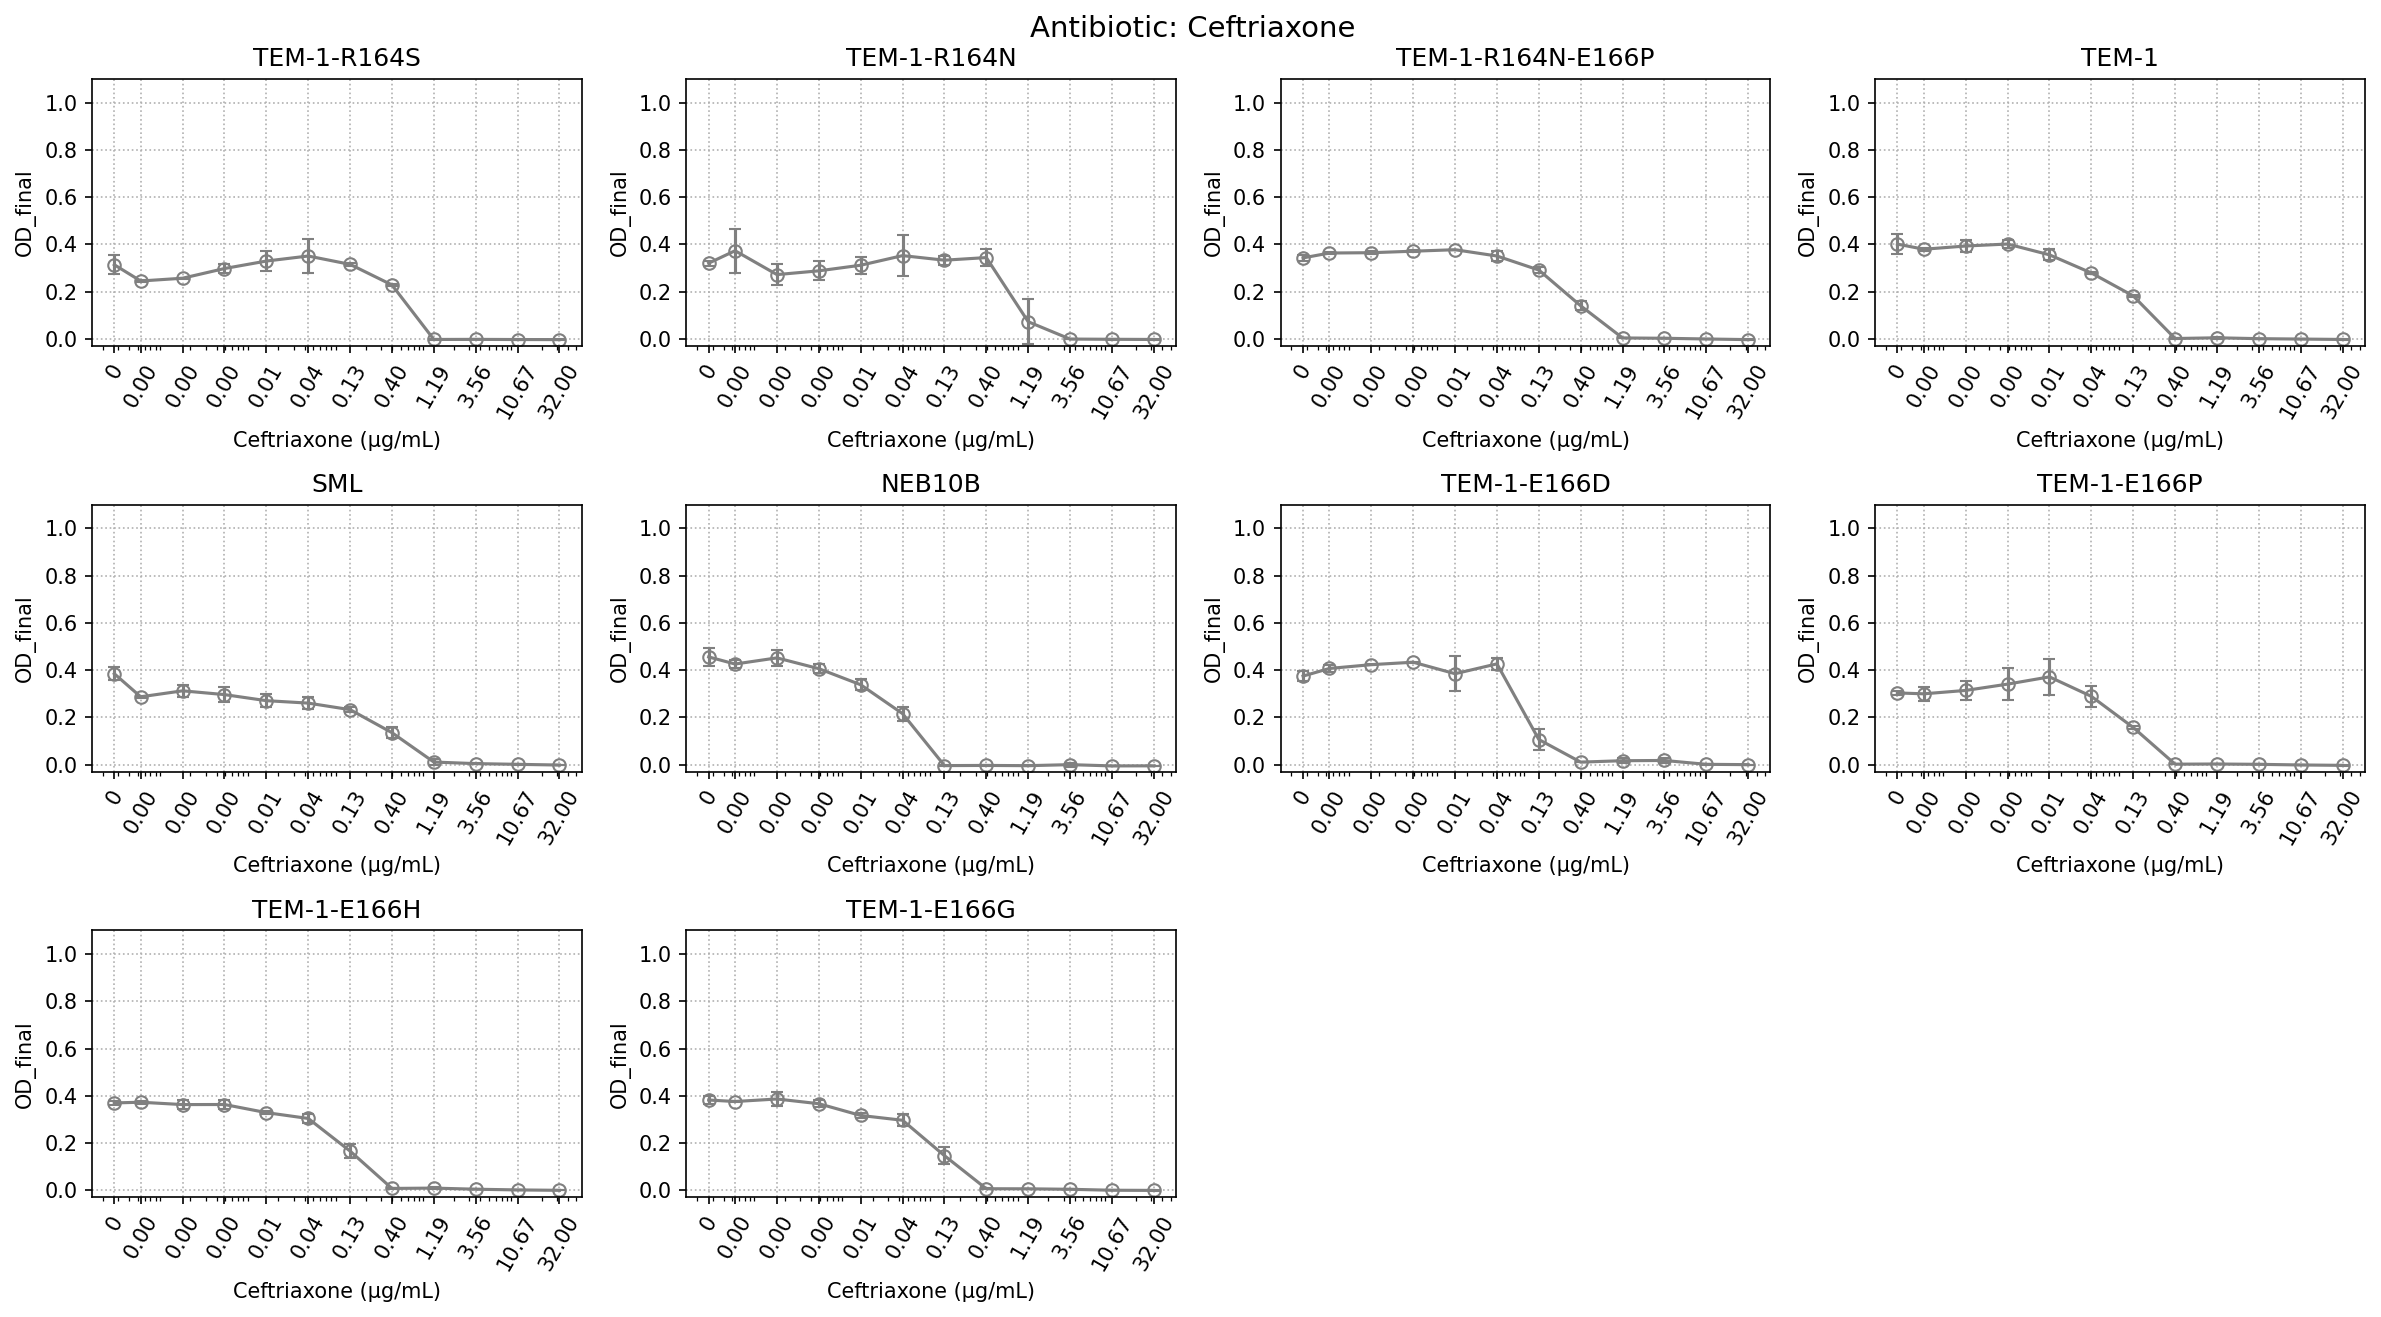

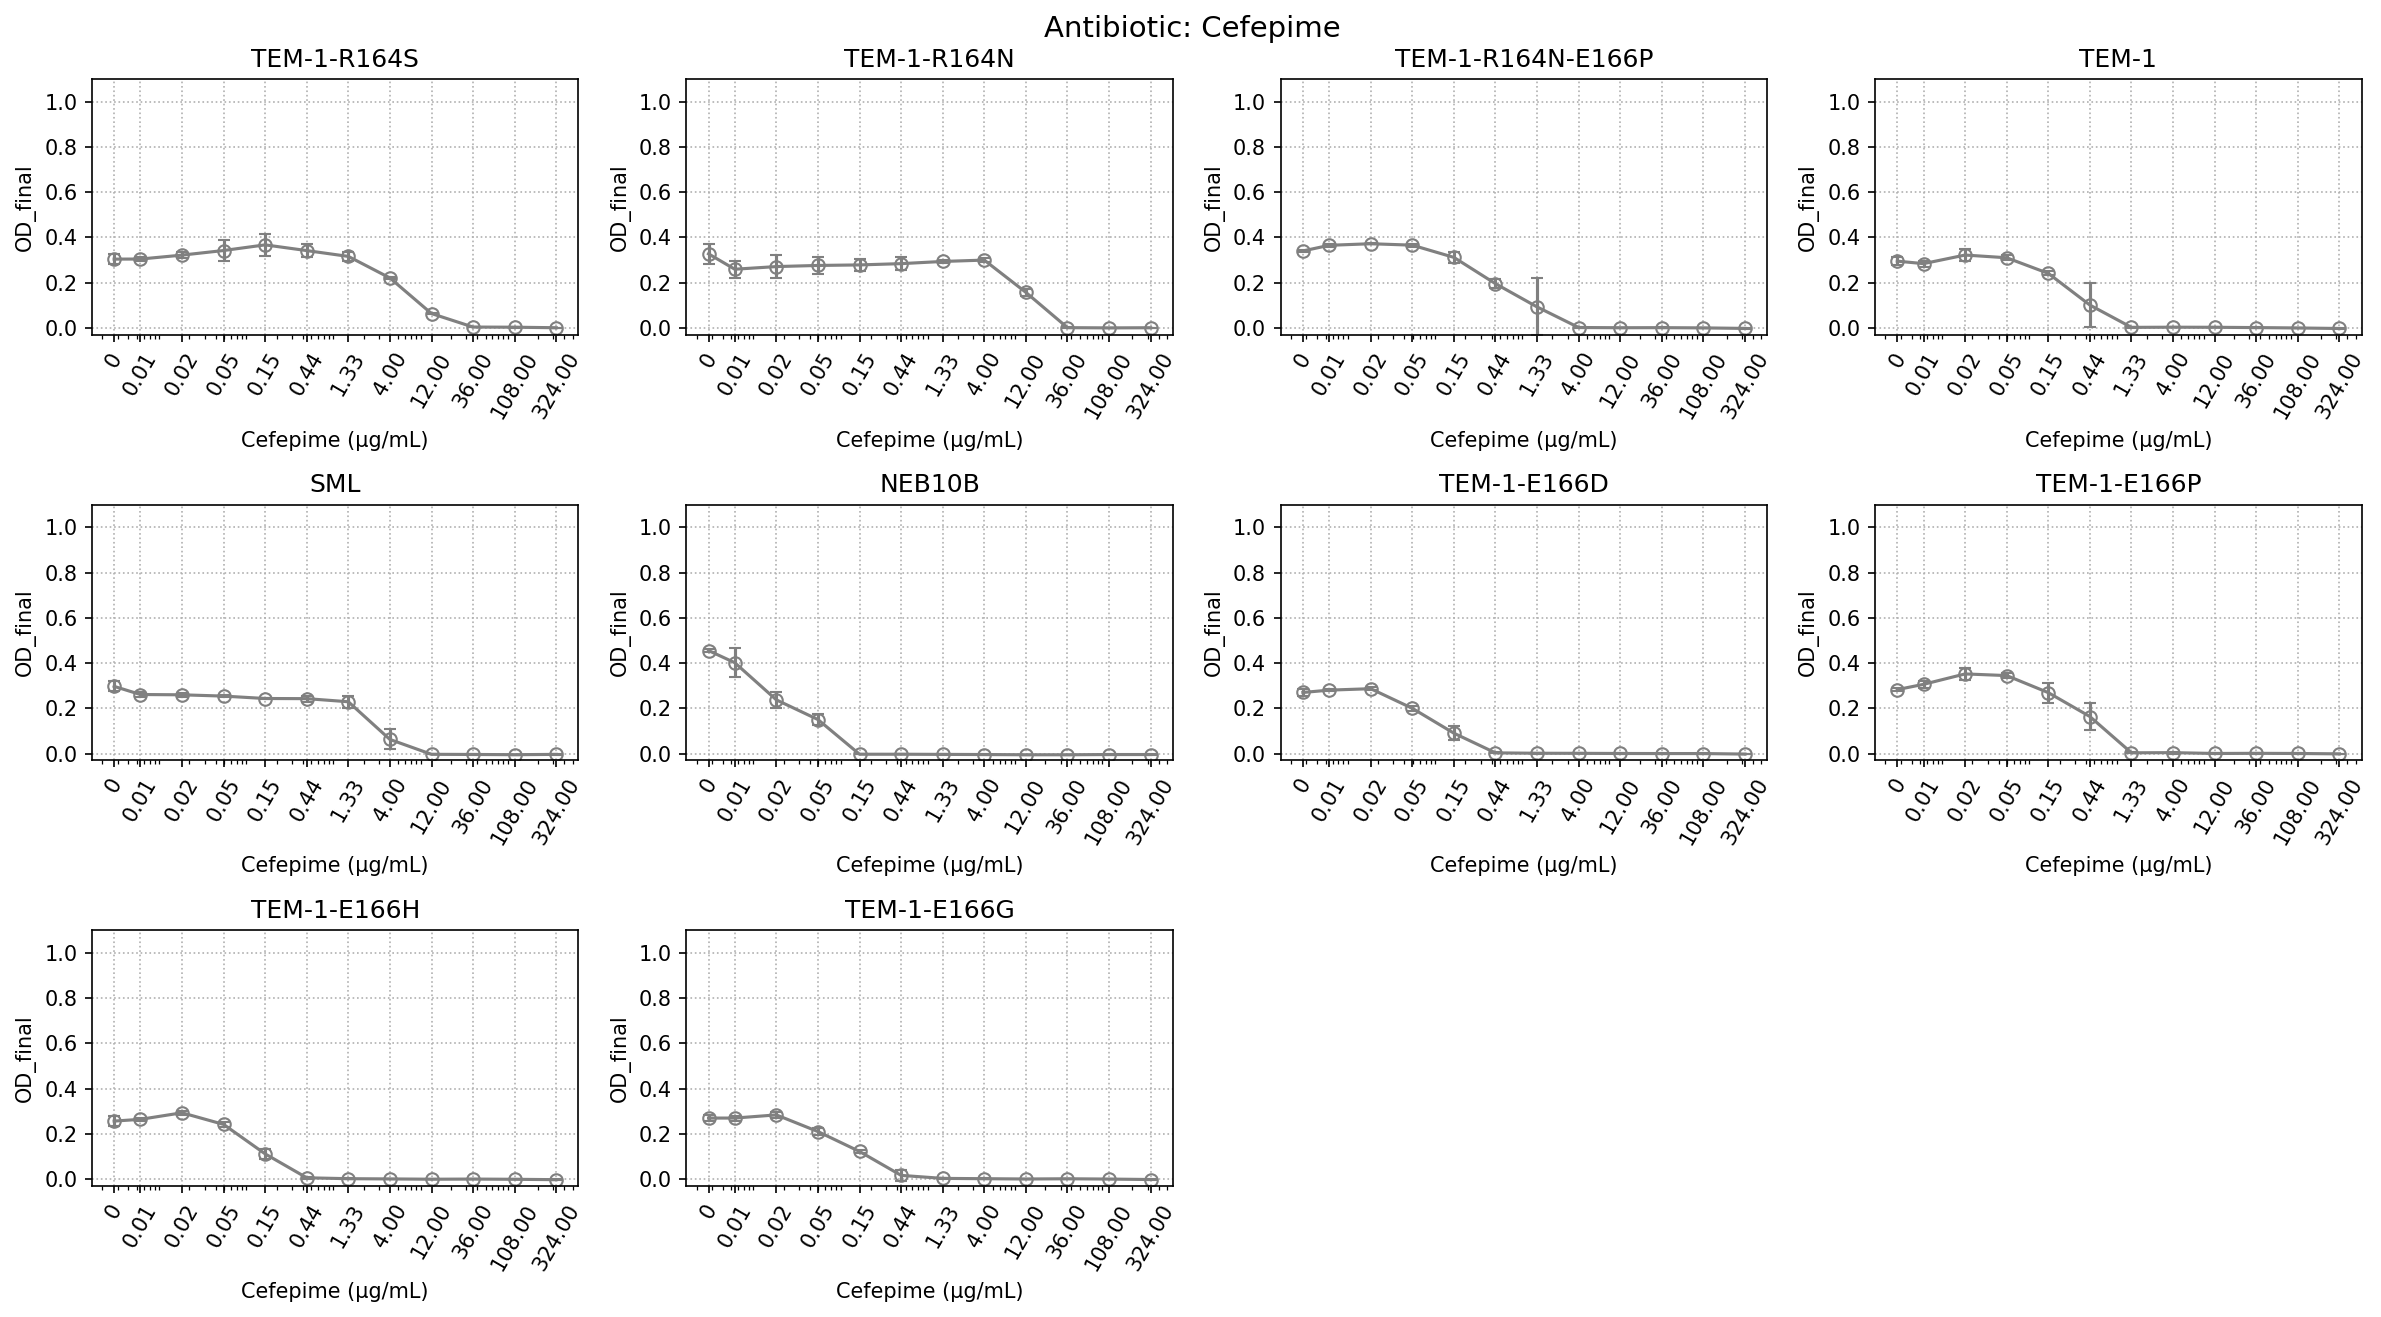

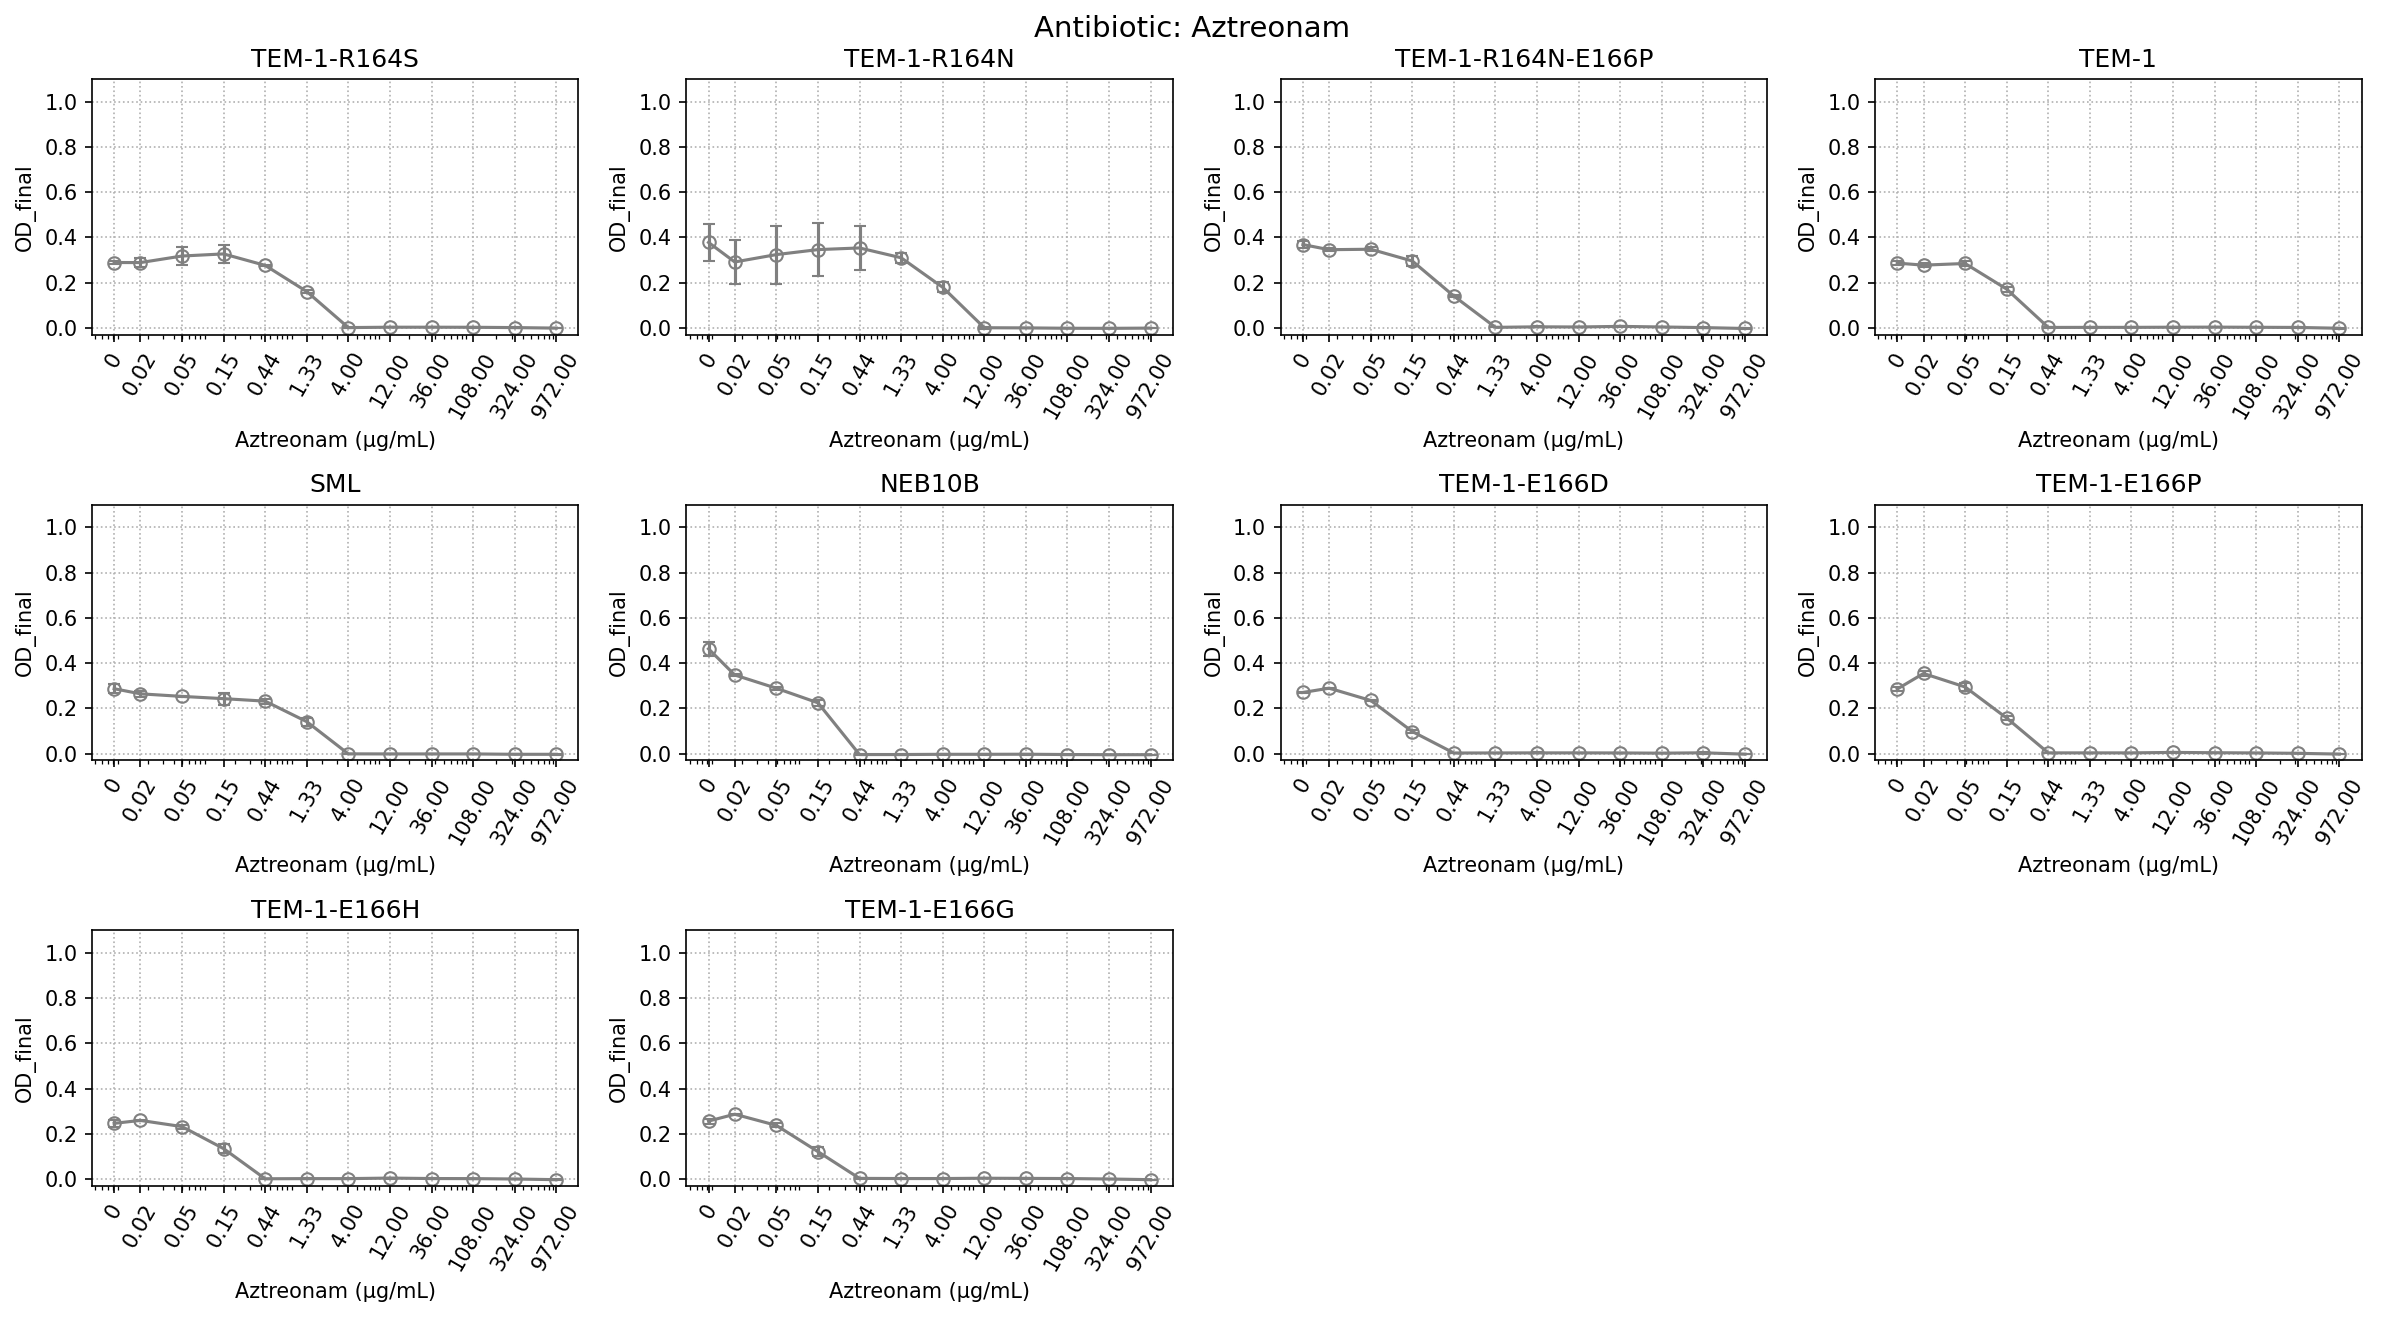

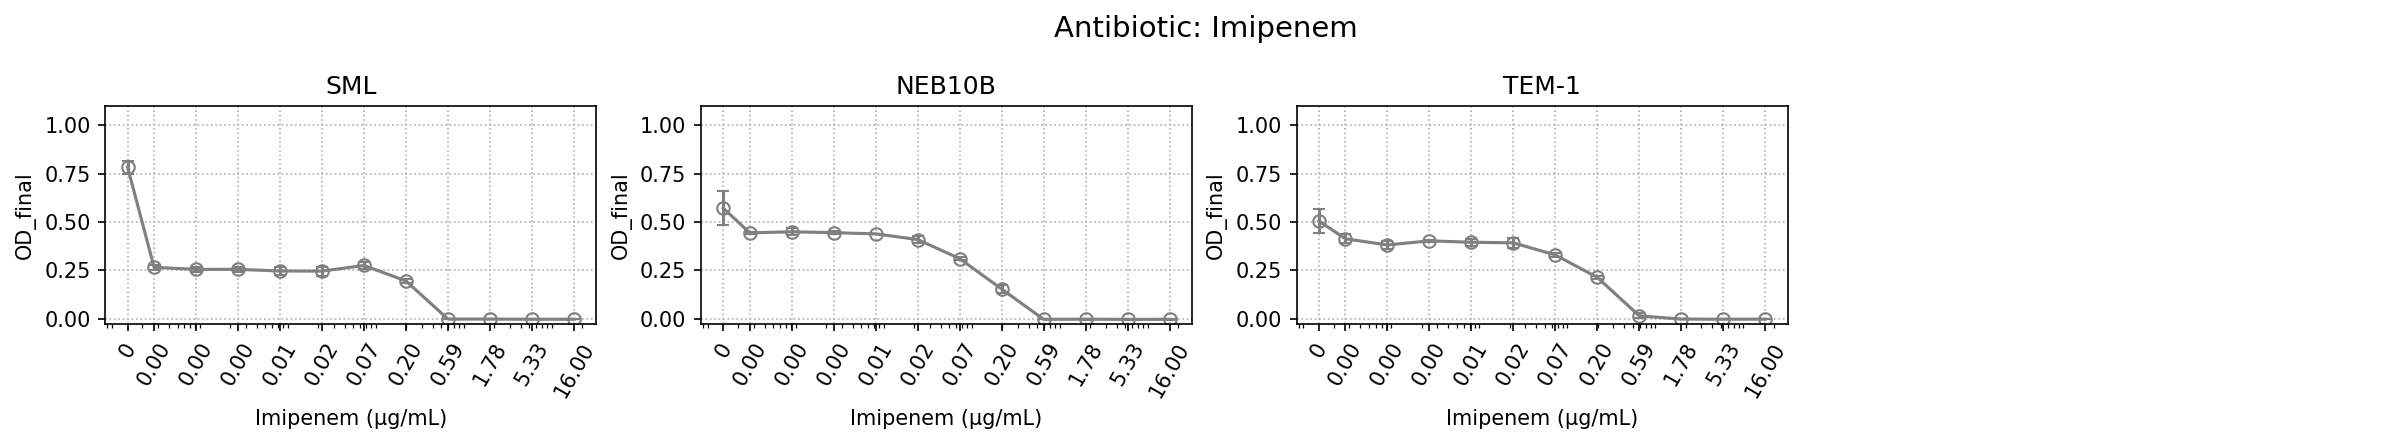

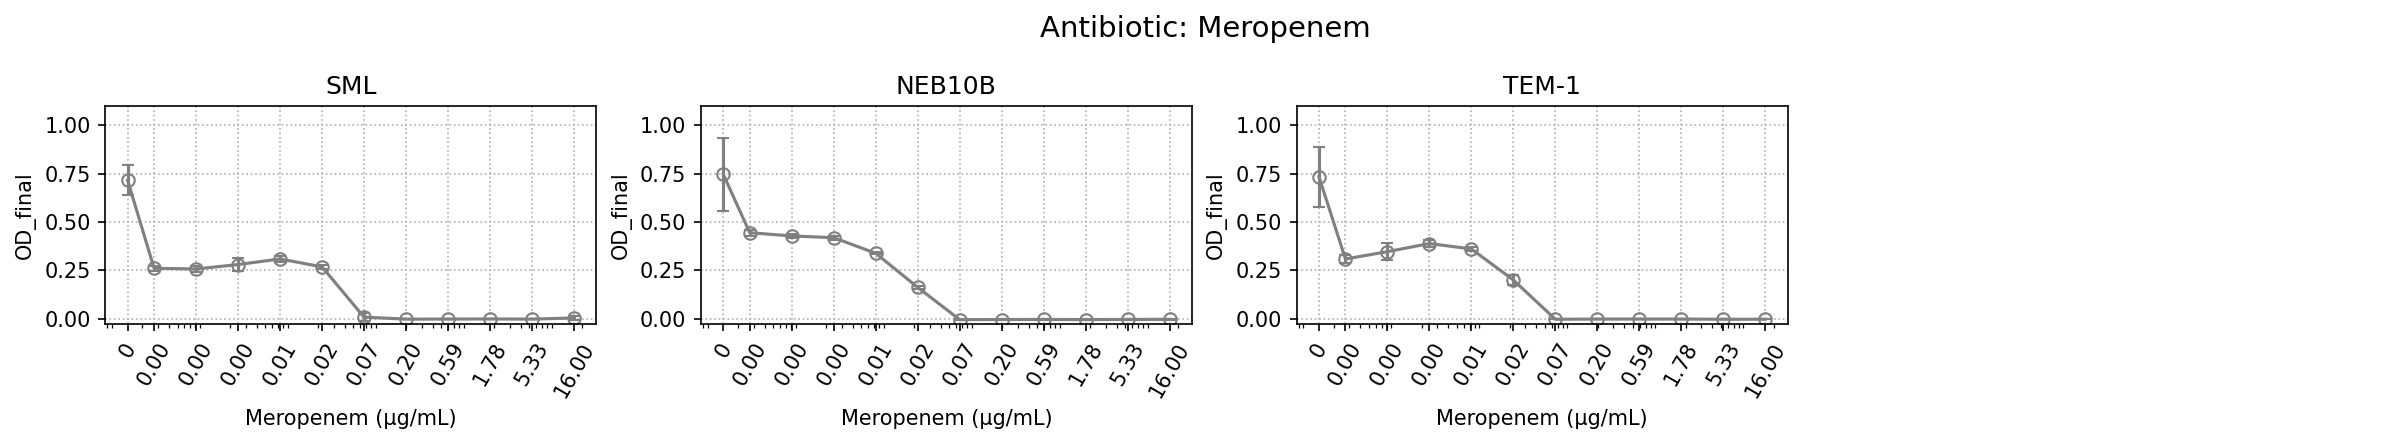

In [15]:
# Plot all dose-response curves in the df_analysis tables (might take too long)
for drug in antibiotics:
    if not pd.isna(drug):
        plategig.static.plot_od_final_for_selected_antibiotic(
            df_analysis,
            plategig.static.plot_dose_response_curve_errorbar,
            drug,
            strain_colors={})

In [16]:
valid_combinations = plategig.static.prep_valid_combinations(df_analysis,
    multiplex=['Strain', 'Antibiotic'])
valid_combinations

Strain   Antibiotic
0   NEB10B   Ampicillin
1   NEB10B  Ceftazidime
2    TEM-1   Ampicillin
3    TEM-1  Ceftazidime
4      SML   Ampicillin
..     ...          ...
75  NEB10B    Meropenem
76   TEM-1     Imipenem
77   TEM-1    Meropenem
78     SML     Imipenem
79     SML    Meropenem

[80 rows x 2 columns]

In [17]:
growth_features = plategig.static.apply_phenotyper(df_analysis, valid_combinations)
growth_features = plategig.static.cap_growth_features_within_experiment_range(growth_features)
growth_features

Strain   Antibiotic Status          IC50           MIC  IC50_ci_lower  \
0   NEB10B   Ampicillin   PASS  1.502459e+00      1.713343   8.311576e-09   
1   NEB10B  Ceftazidime   PASS  1.401086e-01      0.352968   1.325715e-01   
2    TEM-1   Ampicillin   PASS  9.789133e+03  12396.879532   9.535711e+03   
3    TEM-1  Ceftazidime   PASS  2.645481e-01      1.662690   1.827864e-01   
4      SML   Ampicillin   PASS  3.903671e+03   7640.561019   3.821867e+03   
..     ...          ...    ...           ...           ...            ...   
75  NEB10B    Meropenem   PASS  7.652906e-03      0.136074   4.370202e-04   
76   TEM-1     Imipenem   PASS  1.753479e-01      0.989431   1.551181e-01   
77   TEM-1    Meropenem   PASS  1.683183e-02      0.099051   2.447178e-04   
78     SML     Imipenem   PASS  1.620458e-08      0.004650   3.891042e-09   
79     SML    Meropenem   PASS  1.051770e-02      0.520964   8.688145e-09   

    IC50_ci_upper  MIC_ci_lower  MIC_ci_upper  max_growth  hill_coeff  \
0        1.521278      0.000028      1.821775    0.336647   22.417899   
1        0.146261      0.264651      0.410597    0.339401    3.186764   
2    10002.322473  10861.339275  12547.156688    0.384189   12.467356   
3        0.351946      1.148844      2.248382    0.389808    1.601833   
4     3980.257228   6918.085304   8343.318874    0.369617    4.384519   
..            ...           ...           ...         ...         ...   
75       0.014627      0.071944      0.177634    0.570858    1.023045   
76       0.195375      0.811232      1.274763    0.415649    1.701635   
77       0.023523      0.024752      0.293566    0.448362    1.661302   
78       0.232762      0.001076     12.731634    5.197236    0.234297   
79       0.036173      0.000047      0.684266    0.448802    0.754477   

    ic50_threshold  mic_threshold  \
0         0.168323       0.016832   
1         0.169700       0.016970   
2         0.192095       0.019209   
3         0.194904       0.019490   
4         0.184808       0.018481   
..             ...            ...   
75        0.285429       0.028543   
76        0.207825       0.020782   
77        0.224181       0.022418   
78        2.598618       0.259862   
79        0.224401       0.022440   

                                                x_fit  \
0   [0.25402631712645435, 0.28784201885268434, 0.3...   
1   [0.008230452674897122, 0.009326081410826978, 0...   
2   [0.254026315, 0.2878420164674974, 0.3261592266...   
3   [0.008230452674897122, 0.009326081410826978, 0...   
4   [0.254026315, 0.2878420164674974, 0.3261592266...   
..                                                ...   
75  [0.00013548070246744226, 0.0001535157433880983...   
76  [0.00013548070246744226, 0.0001535157433880983...   
77  [0.00013548070246744226, 0.0001535157433880983...   
78  [0.00013548070246744226, 0.0001535157433880983...   
79  [0.00013548070246744226, 0.0001535157433880983...   

                                                y_fit  \
0   [0.3366467634024896, 0.3366467634024896, 0.336...   
1   [0.33935998463275047, 0.33934016650153626, 0.3...   
2   [0.38418916985487095, 0.38418916985487095, 0.3...   
3   [0.38831193275163706, 0.38798180589517195, 0.3...   
4   [0.369616999786307, 0.369616999786307, 0.36961...   
..                                                ...   
75  [0.5617951949628497, 0.5605814174098199, 0.559...   
76  [0.41564697550618296, 0.4156464767640205, 0.41...   
77  [0.44821293777823323, 0.44817864129503937, 0.4...   
78  [0.5589691061262856, 0.5445292161515368, 0.530...   
79  [0.43258156139966686, 0.43104114539560495, 0.4...   

                                       ic50_bootstrap  insufficient_drug  
0   [1.498597878055957, 1.5081490353485998, 8.2645...              False  
1   [0.13816989615496636, 0.1343814229369494, 0.14...              False  
2   [9770.694976008012, 9679.225518985204, 9552.69...              False  
3   [0.23484038468505283, 0.22619055904865745, 0.2...              False  
4   [3934.76

In [18]:
growth_features.query('Strain == "SML"')

Strain   Antibiotic Status          IC50          MIC  IC50_ci_lower  \
4     SML   Ampicillin   PASS  3.903671e+03  7640.561019   3.821867e+03   
5     SML  Ceftazidime   PASS  4.000794e+00   199.638338   1.403269e+00   
38    SML   Cefotaxime   PASS  1.817112e-01     5.474937   1.313000e-01   
39    SML  Ceftriaxone   PASS  2.714888e-01     2.676413   1.798327e-01   
72    SML     Cefepime   PASS  2.654817e+00     7.464891   2.230327e+00   
73    SML    Aztreonam   PASS  1.381117e+00     4.001903   1.243508e+00   
78    SML     Imipenem   PASS  1.620458e-08     0.004650   3.891042e-09   
79    SML    Meropenem   PASS  1.051770e-02     0.520964   8.688145e-09   

    IC50_ci_upper  MIC_ci_lower  MIC_ci_upper  max_growth  hill_coeff  \
4     3980.257228   6918.085304   8343.318874    0.369617    4.384519   
5        8.715231     65.587050    423.614484    0.313541    0.753051   
38       0.259593      3.693910      7.157759    0.317724    0.864608   
39       0.355571      1.846717      5.136596    0.310228    1.286730   
72       3.566344      4.363778     11.589909    0.259881    2.848074   
73       1.523076      3.151642      4.690998    0.258188    2.767649   
78       0.232762      0.001076     12.731634    5.197236    0.234297   
79       0.036173      0.000047      0.684266    0.448802    0.754477   

    ic50_threshold  mic_threshold  \
4         0.184808       0.018481   
5         0.156770       0.015677   
38        0.158862       0.015886   
39        0.155114       0.015511   
72        0.129940       0.012994   
73        0.129094       0.012909   
78        2.598618       0.259862   
79        0.224401       0.022440   

                                                x_fit  \
4   [0.254026315, 0.2878420164674974, 0.3261592266...   
5   [0.008230452674897122, 0.009326081410826978, 0...   
38  [0.0002709614049348845, 0.00030703148677619664...   
39  [0.0002709614049348845, 0.00030703148677619664...   
72  [0.002743485, 0.0031086946729442194, 0.0035225...   
73  [0.008230455000000003, 0.009326084018832661, 0...   
78  [0.00013548070246744226, 0.0001535157433880983...   
79  [0.00013548070246744226, 0.0001535157433880983...   

                                                y_fit  \
4   [0.369616999786307, 0.369616999786307, 0.36961...   
5   [0.31059648685586677, 0.3103089465138002, 0.30...   
38  [0.3165844499858509, 0.3164549493885329, 0.316...   
39  [0.3101849748942678, 0.310177528123265, 0.3101...   
72  [0.2598808891121514, 0.2598808887637026, 0.259...   
73  [0.2581877246266402, 0.2581876503840165, 0.258...   
78  [0.5589691061262856, 0.5445292161515368, 0.530...   
79  [0.43258156139966686, 0.43104114539560495, 0.4...   

                                       ic50_bootstrap  insufficient_drug  
4   [3934.765339693136, 3873.219210315223, 3955.45...              False  
5   [5.498682054659822, 3.5316109983594925, 6.3027...              False  
38  [0.1891668041805974, 0.16482284143645629, 0.19...              False  
39  [0.24862931902795457, 0.2231640972439554, 0.25...              False  
72  [2.7949666874159735, 2.8377523379911715, 2.485...              False  
73  [1.4237525195614673, 1.4803506126319745, 1.479...              False  
78  [4.707138390309488e-09, 7.62760041073447e-09, ...              False  
79  [0.0004929494747074509, 0.00011206790699888569...              False

In [19]:
# growth_features['group'] = growth_features['Strain'].apply(lambda x: re.split(r'[1-9]', x)[0])
# growth_features

In [20]:
strains = list(set(df_analysis['Strain'].str.lower()) - set(['media only', 'cells only', np.nan]))
print(strains)

['tem-1-r164n-e166p', 'tem-1-e166d', 'tem-1-k73a-e166p', 'sml', 'neb10b', 'tem-1-e166h', 'tem-1-r164n', 'tem-1-e166p-n170a', 'tem-1-n132a', 'tem-1-e166p', 'tem-1-n132a-e166p', 'tem-1-e166p-e168a-n170a', 'tem-1-e166g', 'tem-1-e166p-e168a', 'tem-1-k73a', 'tem-1-r164s', 'tem-1']


In [21]:
antibiotics = list(set(df_analysis['Antibiotic'].str.lower()) - set(['media only', 'cells only', np.nan]))
antibiotics

['imipenem',
 'cefepime',
 'ceftazidime',
 'ampicillin',
 'aztreonam',
 'cefotaxime',
 'ceftriaxone',
 'meropenem']

In [22]:
strain_colors = {strain:color for strain, color in zip(strains, sns.color_palette('muted')[:len(strains)])}


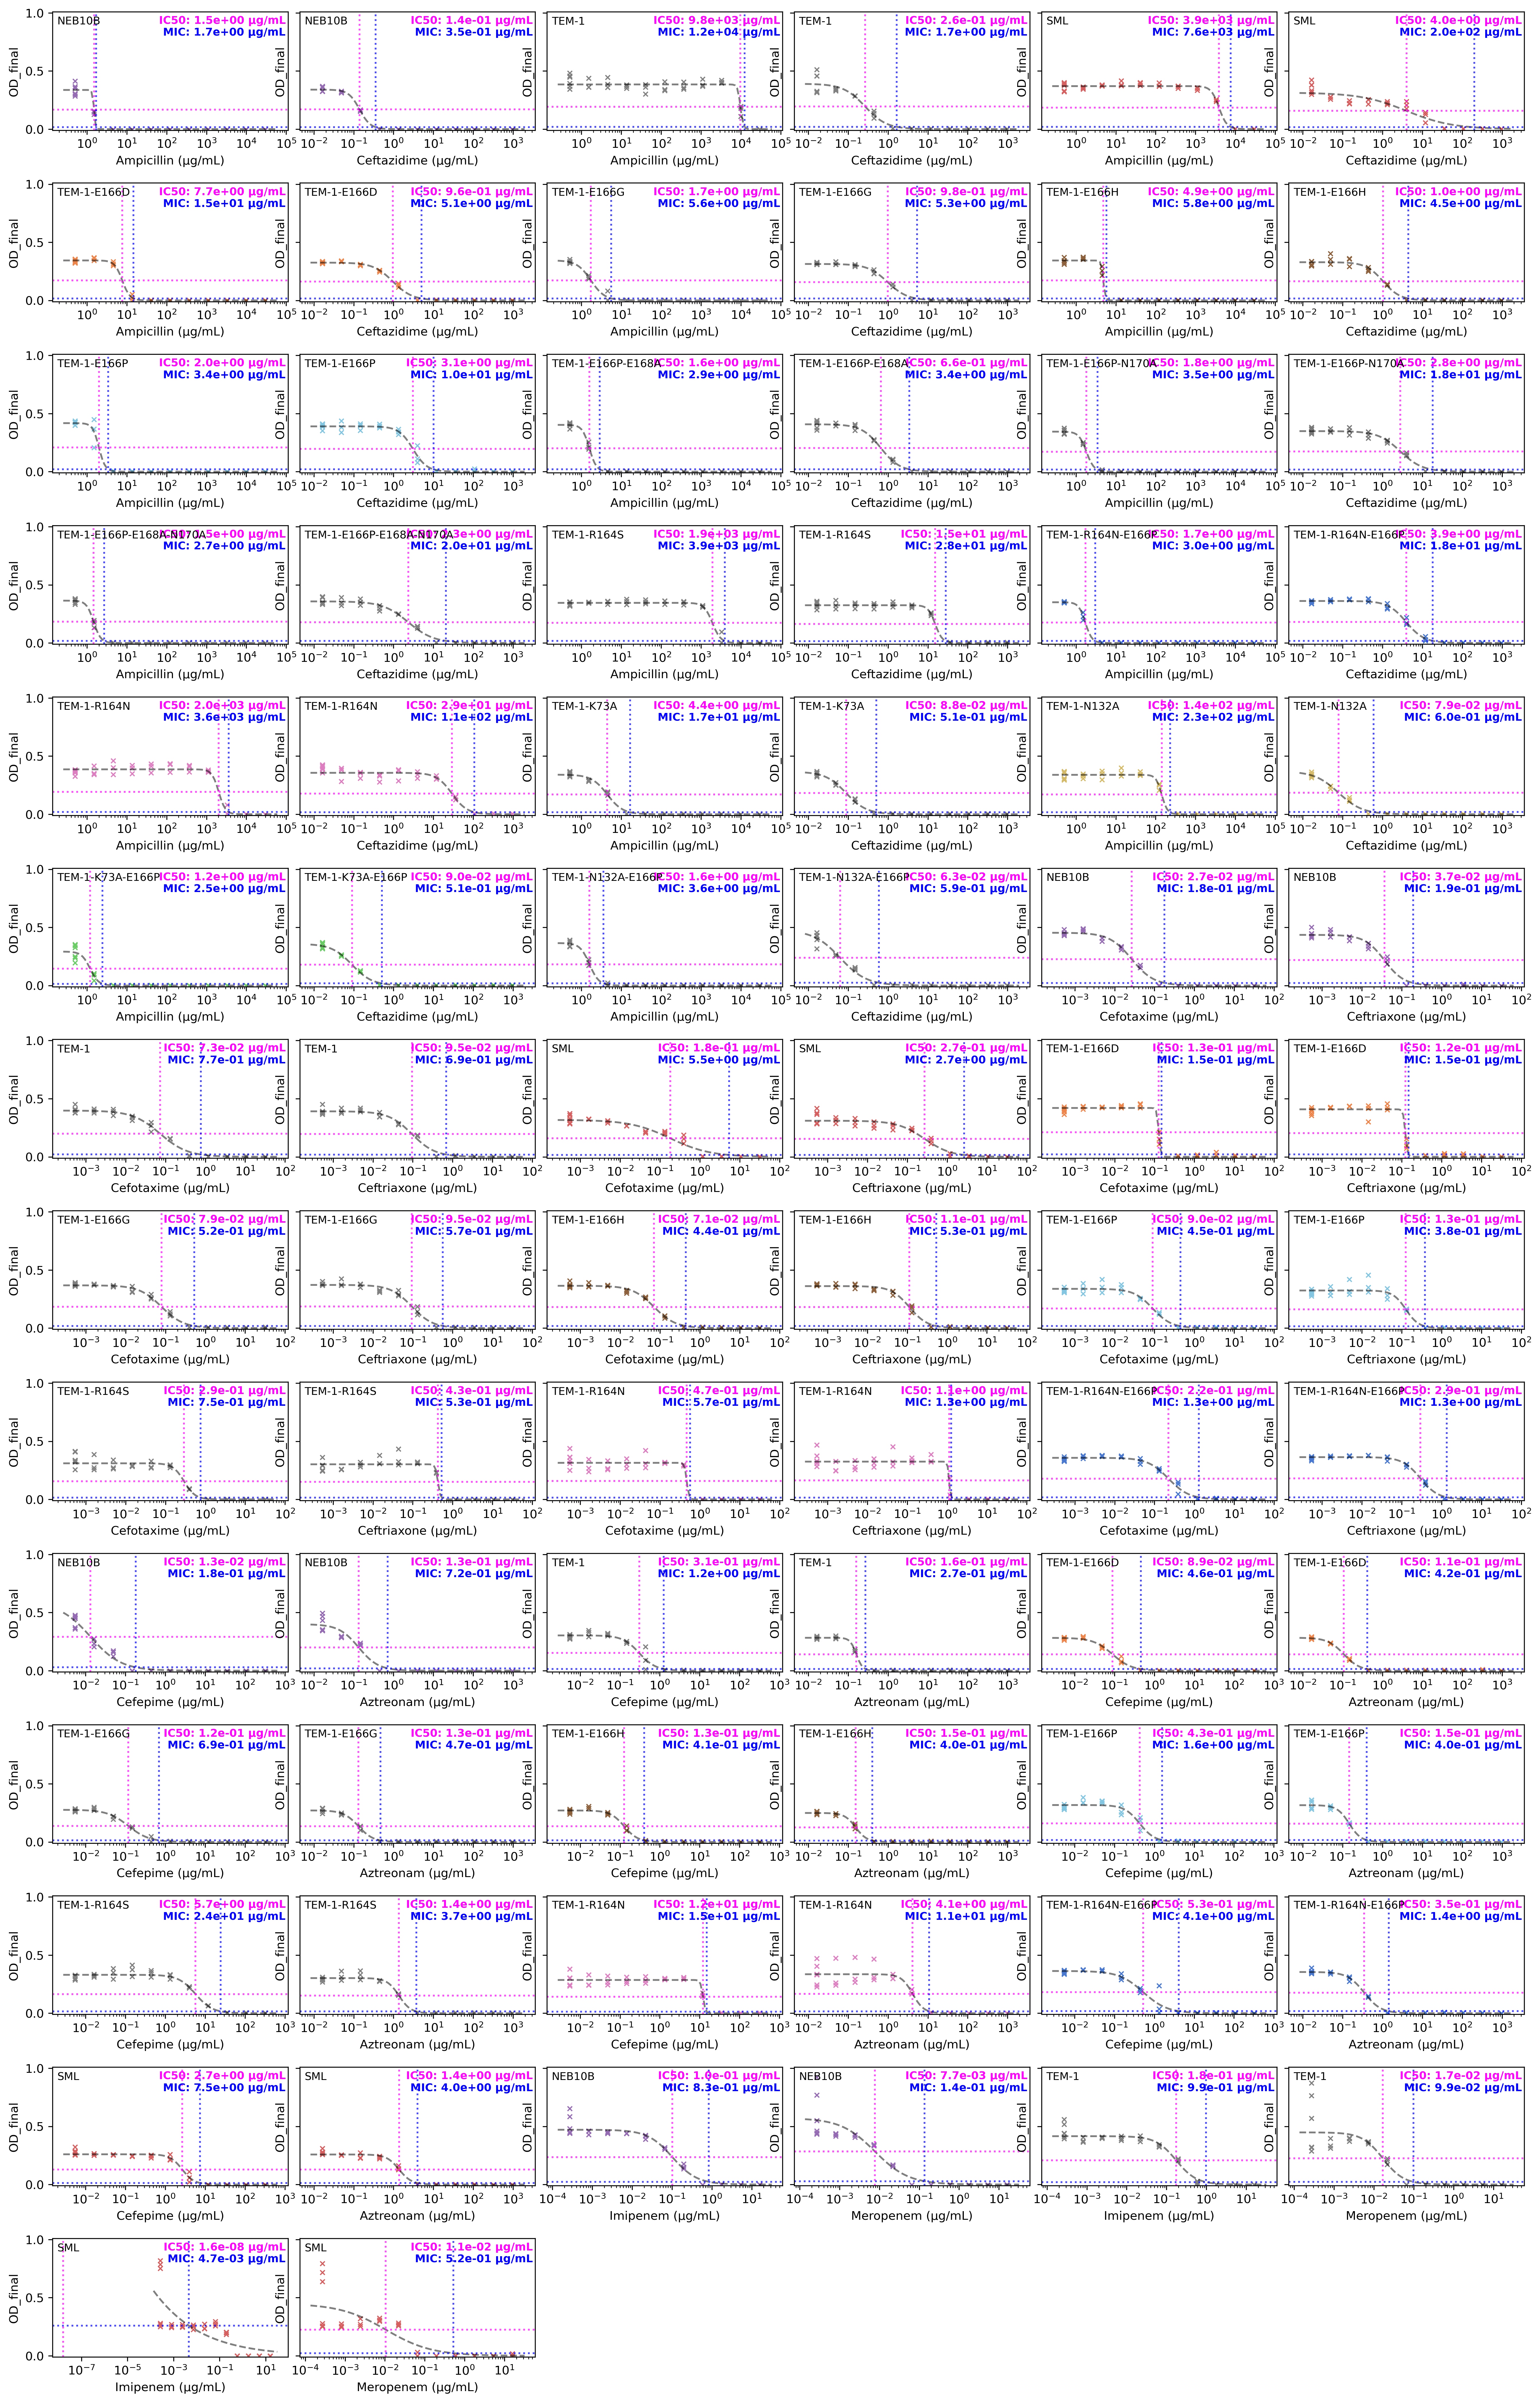

In [23]:
num_drugs = growth_features['Antibiotic'].nunique()
num_experiments = growth_features.shape[0]
num_cols = 6
num_rows = num_experiments//num_cols + (num_experiments % num_cols > 0)
# num_cols = num_experiments//num_drugs
# fig, axes = plt.subplots(num_experiments//num_replicates, num_replicates,
#                        figsize=(num_replicates*3, num_experiments*2), dpi=90)
fig, axes = plt.subplots(num_rows, num_cols,
                       figsize=(num_cols*3, num_rows*2), dpi=300)

for ix, row in growth_features.iterrows():
    plategig.static.plot_dose_response_curve_fit(df_analysis,
                                                growth_features=growth_features,
                                                strain_colors=strain_colors,
                                                strain=row['Strain'],
                                                antibiotic=row['Antibiotic'],
                                                ax=axes.flat[ix])
    
    if row['Status'] == 'FAIL':
        axes.flat[ix].text(0.5, 0.5, f'FAIL', color='red', fontsize=12, fontweight='bold',
                        ha='center', va='center', transform=axes.flat[ix].transAxes)
        # gray out the entire axes
        axes.flat[ix].set_facecolor('lightgray')
    if ix % num_cols != 0:
        axes.flat[ix].set_yticklabels([])
# Hide the rest of the axes
for ix in range(num_experiments, num_cols*num_rows):
    axes.flat[ix].axis('off')
    
fig.tight_layout()
# set empty space between subplots
fig.subplots_adjust(wspace=0.05)
fig.savefig(PROJECT_PATH / PROJECT_ID / 'figures' / f'SML IC50 fits.png', dpi=300, bbox_inches='tight')

In [24]:
#### Graphes the IC50 values for each with a confindence interval
    ### looks like it pulls growth_features

final_chart = alt.vconcat()
for drug in sorted(growth_features['Antibiotic'].unique()):
    select_cols = ['Strain','Antibiotic','Status','IC50','IC50_ci_lower','IC50_ci_upper', 'insufficient_drug']
    filtered_growth_features = growth_features[select_cols]
    filtered_growth_features = filtered_growth_features.query(f'Antibiotic == "{drug}" & Status == "PASS"')
    filtered_growth_features['StrainGroup'] = filtered_growth_features['Strain']#.str.extract(r'(\D+)')

    base = alt.Chart(filtered_growth_features).encode(
        x=alt.X('Strain', axis=alt.Axis(labelAngle=-45, labelLimit=0)),
    ).properties(width=700, height=300)

    ic50 = base.encode(
        y=alt.Y('IC50:Q', scale=alt.Scale(type="log")),
        color=alt.Color("StrainGroup:N")
    ).mark_point(filled=True, size=200)

    error_bars = base.mark_errorbar(ticks=True, size=10, thickness=2).encode(
        alt.Y("IC50_ci_lower:Q", scale=alt.Scale(type="log")).title('IC50'),
        alt.Y2("IC50_ci_upper:Q"),
        color='StrainGroup'
    )

    # Create a dagger symbol on the bars with insufficient_drug flag is true
    dagger = base.mark_text(align='center', baseline='middle', fontSize=14, color='black', fontWeight='bold', dy=-20, dx=0).encode(
        y=alt.Y('IC50'),
        text=alt.condition(
            alt.datum.insufficient_drug, if_true=alt.value("‡"), if_false=alt.value("")
            )
    )

    layered_chart = alt.layer(ic50, error_bars, dagger).properties(title=drug)
    final_chart &= layered_chart

final_chart = final_chart.resolve_scale(y='independent', x='independent').configure_axis(
    labelFontSize=16,
    titleFontSize=16,
).configure_title(
    fontSize=16,
    anchor='middle',
).configure_legend(
    titleFontSize=16,
    labelFontSize=16,
    labelLimit=0,
    symbolLimit=50,
)

final_chart = final_chart.configure_title(anchor='middle')
final_chart.save(PROJECT_PATH / PROJECT_ID / 'figures' / f'SML IC50 combined.png', scale_factor=2)
final_chart.show()

alt.VConcatChart(...)

In [25]:
#### Graphs the MIC values for each with a confidence interval
    ### looks like it pulls growth_features

final_chart = alt.vconcat()
for drug in sorted(growth_features['Antibiotic'].unique()):
    select_cols = ['Strain','Antibiotic','Status','MIC','MIC_ci_lower','MIC_ci_upper', 'insufficient_drug']
    filtered_growth_features = growth_features[select_cols]
    filtered_growth_features = filtered_growth_features.query(f'Antibiotic == "{drug}" & Status == "PASS"')
    filtered_growth_features['StrainGroup'] = filtered_growth_features['Strain']#.str.extract(r'(\D+)')

    base = alt.Chart(filtered_growth_features).encode(
        x=alt.X('Strain', axis=alt.Axis(labelAngle=-45, labelLimit=0)),
    ).properties(width=700, height=300)

    mic = base.encode(
        y=alt.Y('MIC:Q', scale=alt.Scale(type="linear")),
        color=alt.Color("StrainGroup:N")
    ).mark_point(filled=True, size=200)

    error_bars = base.mark_errorbar(ticks=True, size=10, thickness=2).encode(
        alt.Y("MIC_ci_lower:Q", scale=alt.Scale(type="linear")).title('MIC'),
        alt.Y2("MIC_ci_upper:Q"),
        color='StrainGroup'
    )

    # Create a dagger symbol on the bars with insufficient_drug flag is true
    dagger = base.mark_text(align='center', baseline='middle', fontSize=14, color='black', fontWeight='bold', dy=-20, dx=0).encode(
        y=alt.Y('MIC'),
        text=alt.condition(
            alt.datum.insufficient_drug, if_true=alt.value("‡"), if_false=alt.value("")
            )
    )

    layered_chart = alt.layer(mic, error_bars, dagger).properties(title=drug)
    final_chart &= layered_chart

final_chart = final_chart.resolve_scale(y='independent', x='independent').configure_axis(
    labelFontSize=16,
    titleFontSize=16,
).configure_title(
    fontSize=16,
    anchor='middle',
).configure_legend(
    titleFontSize=16,
    labelFontSize=16,
    labelLimit=0,
    symbolLimit=50,
)

final_chart = final_chart.configure_title(anchor='middle')
final_chart.save(PROJECT_PATH / PROJECT_ID / 'figures' / f'SML MIC combined.png', scale_factor=2)
final_chart.show()

alt.VConcatChart(...)